In [2]:
%cd ..

/home/jayant/Projects/recurse/hn_analyze


In [83]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from newspaper import Article
from collections import defaultdict
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering
from sklearn.manifold import MDS
import logging
logging.basicConfig(level=logging.INFO)

In [84]:
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.figsize'] = [8, 5]

Populating the interactive namespace from numpy and matplotlib


In [85]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
from IPython.display import HTML

In [86]:
from models.lda import HnLdaModel, HnLdaMalletModel
from models.utils import HnCorpus
from models.search_index import SearchIndex
import pickle

In [87]:
%matplotlib inline

In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
DATA_DIR = 'data/'
RAW_ARTICLES_DIR = os.path.join(DATA_DIR, 'articles', 'raw')
PARSED_ARTICLES_DIR = os.path.join(DATA_DIR, 'articles', 'parsed')
CORPUS_DIR = os.path.join(DATA_DIR, 'corpora')
TEST_ARTICLES_DIR = os.path.join(DATA_DIR, 'articles', 'test')
MALLET_PATH = '/home/jayant/Projects/recurse/mallet-2.0.8/bin/mallet'

In [250]:
hn_df = pd.read_csv('./data/HN_posts_year_to_Sep_26_2016.csv')

In [251]:
hn_df.head()

id                                              title  \
0  12579008  You have two days to comment if you want stem ...   
1  12579005                         SQLAR  the SQLite Archiver   
2  12578997  What if we just printed a flatscreen televisio...   
3  12578989                                  algorithmic music   
4  12578979  How the Data Vault Enables the Next-Gen Data W...   

                                                 url  num_points  \
0  http://www.regulations.gov/document?D=FDA-2015...           1   
1   https://www.sqlite.org/sqlar/doc/trunk/README.md           1   
2  https://medium.com/vanmoof/our-secrets-out-f21...           1   
3  http://cacm.acm.org/magazines/2011/7/109891-al...           1   
4  https://www.talend.com/blog/2016/05/12/talend-...           1   

   num_comments        author      created_at  
0             0       altstar  9/26/2016 3:26  
1             0      blacksqr  9/26/2016 3:24  
2             0  pavel_lishin  9/26/2016 3:19  
3             0  poindontcare  9/26/2016 3:16  
4             0   markgainor1  9/26/2016 3:14

In [252]:
hn_df.describe()

id     num_points   num_comments
count  2.931190e+05  293119.000000  293119.000000
mean   1.133046e+07      15.025324       6.525544
std    6.961055e+05      58.504103      30.376319
min    1.017690e+07       1.000000       0.000000
25%    1.071636e+07       1.000000       0.000000
50%    1.130303e+07       2.000000       0.000000
75%    1.193152e+07       4.000000       1.000000
max    1.257901e+07    5771.000000    2531.000000

In [253]:
min_points_threshold = 50  # Remove all posts with points less than threshold to eliminate noise
hn_df_trimmed = hn_df[hn_df['num_points'] > 50]

In [254]:
hn_df_trimmed = hn_df_trimmed[pd.notnull(hn_df_trimmed['url'])]  # Remove posts without valid urls

In [255]:
print(hn_df_trimmed.count())
hn_df_trimmed.head(10)

id              20148
title           20148
url             20148
num_points      20148
num_comments    20148
author          20148
created_at      20148
dtype: int64


id                                              title  \
63   12578100  Adobe and Berkeley's new deep learning image e...   
67   12578028                        Appropriate Uses for SQLite   
87   12577792    Smart pointers and move semantics in modern C++   
88   12577787  UnGoogled Chromium: Chromium with enhanced pri...   
96   12577685  What I Learned from a Stroke at 26: Make Time ...   
99   12577652  Chelsea Manning's 14 days in solitary for suic...   
103  12577629         The Fundamental Limits of Machine Learning   
111  12577497  Marc Andreessen suddenly deletes all his tweet...   
127  12577331  Designing and producing 2FA tokens to sell on ...   
130  12577283                       Software Development at 1 Hz   

                                                   url  num_points  \
63                     https://github.com/junyanz/iGAN          52   
67                   https://sqlite.org/whentouse.html         125   
87   https://www.oreilly.com/ideas/2-major-reasons-...          55   
88       https://github.com/Eloston/ungoogled-chromium         251   
96   http://www.nytimes.com/2016/09/25/jobs/what-i-...          81   
99   https://www.amnesty.org.uk/press-releases/chel...          53   
103  http://nautil.us/blog/the-fundamental-limits-o...          56   
111  https://techcrunch.com/2016/09/25/marc-andrees...          61   
127  https://conorpp.com/2016/09/23/designing-and-p...         138   
130  https://medium.com/@MartinCracauer/software-de...         100   

     num_comments        author       created_at  
63              8       visionp  9/25/2016 23:44  
67             56     ftclausen  9/25/2016 23:27  
87             40      severine  9/25/2016 22:27  
88            120        kawera  9/25/2016 22:26  
96             28  allsystemsgo  9/25/2016 21:58  
99             34   robin_reala  9/25/2016 21:51  
103            11       dnetesn  9/25/2016 21:47  
111            54         smb06  9/25/2016 21:15  
127            52       conorpp  9/25/2016 20:45  
130            61      akkartik  9/25/2016 20:34

In [256]:
cached_corpus = HnCorpus('data/articles/parsed/', cache_path='data/articles/article_token_lower_lemma_cache', metadata=hn_df_trimmed)

In [257]:
article_index = SearchIndex(preprocess_tokens=True)

In [258]:
article_index.term_index['alphago']

set()

In [264]:
%time article_index.index(cached_corpus.stream_articles(max_count=None))

KeyboardInterrupt: 

In [263]:
cached_corpus.plot_articles(article_index.query('alphago'), window_size=10)

NameError: name 'hn_corpus' is not defined

In [65]:
cached_corpus.plot_articles(article_index.query('trump'), window_size=10)

/home/jayant/Projects/recurse/hn_analyze/models/utils.py:109: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()



# Topic trends

In [13]:
m = pickle.load(open('data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

In [15]:
m.print_topics()

Topic #99: 0.035*"network" + 0.033*"model" + 0.024*"learning" + 0.024*"neural" + 0.018*"learn" + 0.015*"machine" + 0.014*"deep" + 0.014*"training" + 0.014*"layer" + 0.014*"image"

Topic #29: 0.031*"earth" + 0.027*"space" + 0.021*"star" + 0.021*"planet" + 0.015*"orbit" + 0.014*"moon" + 0.011*"year" + 0.010*"mars" + 0.009*"galaxy" + 0.009*"telescope"

Topic #38: 0.059*"container" + 0.052*"docker" + 0.037*"run" + 0.023*"service" + 0.022*"image" + 0.016*"application" + 0.013*"deploy" + 0.011*"cluster" + 0.010*"machine" + 0.010*"host"

Topic #43: 0.028*"quantum" + 0.020*"theory" + 0.018*"physics" + 0.015*"particle" + 0.013*"universe" + 0.011*"physicist" + 0.010*"wave" + 0.010*"field" + 0.009*"hole" + 0.009*"state"

Topic #56: 0.073*"bitcoin" + 0.031*"transaction" + 0.024*"blockchain" + 0.021*"network" + 0.015*"wright" + 0.013*"block" + 0.012*"ethereum" + 0.012*"trust" + 0.012*"currency" + 0.011*"exchange"

Topic #70: 0.082*"car" + 0.031*"vehicle" + 0.023*"drive" + 0.020*"tesla" + 0.017*"roa

In [16]:
plotly.offline.iplot(m.topic_trend_plot(44))

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"



In [17]:
plotly.offline.iplot(m.topic_trend_plot(11))

Topic #11: 0.022*"flight" + 0.018*"fly" + 0.016*"air" + 0.015*"space" + 0.015*"aircraft" + 0.014*"launch" + 0.014*"plane" + 0.014*"drone" + 0.012*"pilot" + 0.012*"rocket"



In [18]:
plotly.offline.iplot(m.topic_trend_plot(66))

Topic #66: 0.033*"google" + 0.032*"computer" + 0.027*"technology" + 0.019*"machine" + 0.018*"human" + 0.014*"system" + 0.013*"world" + 0.012*"ai" + 0.010*"year" + 0.010*"robot"



In [22]:
m.show_topic_articles(topic_id=44)

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"
---------------------------------------------------------------------
Article #10304864 - https://edwardsnowden.com/
Edwardsnowden.com

Who Is Edward Snowden?

Edward Snowden is a 31 year old US citizen, former Intelligence Community officer and whistleblower. The documents he revealed provided a vital public window into the NSA and its international intelligence partners’ secret mass surveillance programs and capabilities. These revelations generated unprecedented attention around the world on privacy intrusions and digital security, leading to a global debate on the issue.

Snowden worked in various roles within the US Intel


---------------------------------------------------------------------
Article #11748746 - http://www.theguardian.com/us-news/2016/may/22/snowden-whistleblower-prote

Article #11564639 - https://theintercept.com/2016/04/25/how-the-cia-writes-history/
How the CIA writes history

Last summer I paid a visit to Georgetown University’s Lauinger Library as part of my research on legendary CIA counterspy James Jesus Angleton. I went there to investigate Angleton’s famous mole hunt, one of the least flattering episodes of his eventful career. By the early 1960s, Angleton was convinced the KGB had managed to insert a penetration agent high in the ranks of the CIA.

In researching and writing a biography of Angleton, I constantly confront a conundrum: Was the man utterly bri


---------------------------------------------------------------------
Article #10511012 - http://www.theguardian.com/world/2015/nov/04/house-bill-end-warrantless-stingray-surveillance-jason-chaffetz
Congressman introduces bill to end warrantless Stingray surveillance

Legislation from Jason Chaffetz would make it illegal for Stingray technology to be deployed without a warrant: ‘If you’


---------------------------------------------------------------------
Article #10536715 - https://www.eff.org/deeplinks/2015/11/its-no-secret-government-uses-zero-days-offense
The Government Uses Zero Days for Offense

Little by little, the government is opening up about its use of computer security vulnerabilities. Last month, the NSA disclosed that it has historically “released more than 91% of vulnerabilities discovered in products that have gone through our internal review process and that are made and used in the United States.” There should probably be an asterisk or four accompanying that statement. But more on that in a minute. First, it’s worth examining why the government is being even the slig


---------------------------------------------------------------------
Article #11697906 - http://sanfrancisco.cbslocal.com/2016/05/13/hidden-microphones-exposed-as-part-of-government-surveillance-program-in-the-bay-area/
Hidden Microphones Part of Government Surveillance Program in 

Article #12358926 - https://medium.com/@thegrugq/completely-wrong-a300246ad316#.v112fv666
Why the NSA Dump Isn't from an Insider

Completely Wrong

Between Lies and Bad Analysis

A well respected author with a lot of knowledge of the NSA has written an article for Reuters speculating that the ShadowBrokers “leak” was from “another Snowden.” It was not. Although I respect the work that Mr Bamford has done in the past in analysing the NSA, his Reuter’s article is littered with half truths, omissions and faulty analysis.

Probably the only accurate statement in the whole piece.

[Ed: I wanted to do a line by line an


---------------------------------------------------------------------
Article #10997777 - https://theintercept.com/2016/01/28/israeli-drone-feeds-hacked-by-british-and-american-intelligence/
Israeli Drone Feeds Hacked by British and American Intelligence

A MERICAN AND BRITISH INTELLIGENCE secretly tapped into live video feeds from Israeli drones and fighter jets, monitoring

---------------------------------------------------------------------
Article #11857607 - http://arstechnica.co.uk/tech-policy/2016/06/labour-backs-principle-of-investigatory-powers-bill/
Investigatory Powers Bill passes through Commons after Labour backs Tory spy law

Updated June 7, 19:45 BST: On Tuesday night, 444 MPs voted in favour of the third reading of the Investigatory Powers Bill. The SNP, Liberal Democrats, and the Green Party opposed the proposed law representing just 69 votes. The bill will now proceed to the House of Lords.

Original story (evening, June 6)

The UK government's bid to massively ramp up surveillance of Brits' Internet activity has been supported "in principle" by the Labour party after it claimed that "significant demands" were me


---------------------------------------------------------------------
Article #12280387 - http://www.nytimes.com/2016/08/13/us/politics/democratic-party-documents-hack.html?_r=0
Hacker Releases More Democratic Party Documents



---------------------------------------------------------------------
Article #12288118 - http://www.atlasobscura.com/articles/meet-the-cuban-expatriate-who-created-spy-vs-spy
Cuban Cartoonist Fled from Castro and Created 'Spy vs. Spy'

Spy vs. Spy cover by Peter Kuper. (Photo: Courtesy of Peter Kuper/Spy vs Spy © E.C. Publications Inc.)

One of the greatest rivalries of all time has been raging since 1961 between two figures who don’t even have real names.

The pro/antagonists of the long-running gag strip Spy vs. Spy have been trying to one-up each other for decades, and it’s all thanks to a Cuban expatriate who was once accused of being a spy himself.

The creator of Spy vs Spy, Antonio Prohías, had already enjoyed a s


---------------------------------------------------------------------
Article #11533500 - http://arstechnica.com/security/2016/04/flashback-declassified-1970-dod-cybersecurity-document-still-relevant/
Flashback: Declassified 1970 DOD cybersecurity document still rel

---------------------------------------------------------------------
Article #10463076 - http://www.independent.co.uk/news/world/modern-art-was-cia-weapon-1578808.html
Modern art was CIA 'weapon' (1995)

For decades in art circles it was either a rumour or a joke, but now it is confirmed as a fact. The Central Intelligence Agency used American modern art - including the works of such artists as Jackson Pollock, Robert Motherwell, Willem de Kooning and Mark Rothko - as a weapon in the Cold War. In the manner of a Renaissance prince - except that it acted secretly - the CIA fostered and promoted American Abstract Expressionist painting around the world for more than 20 years.

The connection is im


---------------------------------------------------------------------
Article #12152906 - http://motherboard.vice.com/read/judge-orders-yahoo-to-explain-how-it-recovered-deleted-emails-in-drugs-case
Judge Orders Yahoo to Explain How It Recovered Deleted Emails in Drugs Case

A judge has orde

At the National Defense Industrial Association's Ground Robotics Capabilities conference on Thursday, Department of Defense officials discussed the possibility of the US military fielding autonomous armed robots to fight alongside troops or act on their own, particularly in "highly competitive, highly contested space" behind enemy lines. "We have to think about what autonomous kinetic options really look like," said Melissa L. Flagg, a deputy assistant secretary of defense in the DOD's Acquisiti


---------------------------------------------------------------------
Article #10383253 - https://www.eff.org/deeplinks/2015/10/judge-doj-not-all-writs/?
Judge to DOJ: Not All Writs

A federal magistrate judge in Brooklyn took an admirable stand last week when he questioned the government’s authority to compel Apple to unlock a seized mobile device using the All Writs Act. That’s a general-purpose law passed in 1789 that allows a court to require third parties’ assistance to execute a prior o

id                                              title  \
275315  10304864                                  Edwardsnowden.com   
94112   11748746  Snowden calls for whistleblower shield after c...   
233106  10615250  Why its so hard to keep up with how the U.S. g...   
83850   11837578  Snowden Tried to Tell NSA About Surveillance C...   
135036  11400686  Report: FBI moves to interview Clinton over em...   
282784  10250097  George W. Bush Made Retroactive N.S.A. Fix Aft...   
153466  11246429  FBI quietly changes its privacy rules for acce...   
229998  10638705  NSA to shut down bulk phone surveillance progr...   
190110  10960940      How the CIA Helped Produce 'Zero Dark Thirty'   
152923  11251333  Obama Administration Set to Expand Sharing of ...   
269968  10344712  Former NSA Chief Disagrees with Current NSA Ch...   
161974  11179252  Obama Administration Set to Expand Sharing of ...   
12628   12462010  Inside the fight to reveal the CIA's torture s...   
106056  11646685  Archivist Wont Call Torture Report a Permanent...   
35838   12258353  90-year-old Cryptanalytic Efforts Must Stay Se...   
77929   11892334  Clinton approved CIA drone assassinations with...   
191810  10947366  NSA Chief Stakes Out Pro-Encryption Position, ...   
276357  10296606  Latest Snowden Doc Shows NSA Spied on German I...   
236146  10591329  John McCain wants to outlaw encryption that th...   
213645  10766171  Juniper hack has U.S. fearing foreign infiltra...   
138680  11372264               How Clintons email scandal took root   
207454  10817463  NSA Cheerleaders Discover Value of Privacy Onl...   
16752   12422713  FBI: Hillary Clinton Didn't Know 'C' in Emails...   
234774  10601265  Baseless Calls to Expand Surveillance Fit Fami...   
277962  10285918  Edward Snowden promotes global treaty to curta...   
237727  10580412  Times Pulls Article Blaming Encryption in Pari...   
483     12573479  Probe of leaked U.S. NSA hacking tools examine...   
243238  10537801   Why Obama did not stop NSA domestic surveillance   
263280  10393860  Federal Whistleblower Investigator Fired After...   
129498  11449099  The Obama Administration Has Embraced Legal Th...   
...          ...                                                ...   
186989  10982220                     Trying to interview Larry Page   
239340  10567333           Thursday Beirut suicide bombings kill 43   
252284  10469375    USDA Scientist Punished for Pollinator Research   
277467  10289490              Two Forgotten Architects of Silk Road   
80131   11870302  Reviewing Microsoft's Automatic Insertion of T...   
272020  10329644  The nuke detectives  New ways to detect covert...   
84363   11832512           Verifiable Credentials on the Blockchain   
121717  11515106  UC Berkeley student questioned, refused servic...   
177445  11059301  Not-so-secret atomic tests: Why the photograph...   
11473   12473827   The careless errors of credit reporting agencies   
233927  10608547  Baffling Web Trackers by Obfuscating Your Move...   
66234   11996031                  GitHub's 2015 Transparency Report   
146122  11305701                      Limitless Worker Surveillance   
223906  10685960  Anonymous Divided: Inside the Two Warring Hack...   
250570  10482033  Kim Dotcom reveals more about his blockchain-i...   
120848  11522024       Kuwait set to enforce DNA testing law on all   
271369  10334087     Users Have Been Betrayed in the Final TPP Deal   
237446  10582276  Microsoft, Once Infested with Security Flaws, ...   
241472  10550043  Did the FBI Pay a University to Attack Tor Users?   
272460  10326171                                Im Stalins daughter   
292082  10184355  A 1985 Essay from a Bulletin Board System Admi...   
117482  11548552  Firms that paid for Clinton speeches have US g...   
97091   11722573  The TSA is a waste of money that doesn't save ...   
241752  10547959  Not So Securus - Massive Hack of 70 Million Pr...   
262739  10397668  TPP could thwart com

In [23]:
m.show_topic_articles(topic_id=11)

Topic #11: 0.022*"flight" + 0.018*"fly" + 0.016*"air" + 0.015*"space" + 0.015*"aircraft" + 0.014*"launch" + 0.014*"plane" + 0.014*"drone" + 0.012*"pilot" + 0.012*"rocket"
---------------------------------------------------------------------
Article #11460935 - http://techcrunch.com/2016/04/08/spacex-just-landed-a-rocket-on-a-drone-ship-for-the-first-time/
SpaceX just landed a rocket on a drone ship for the first time

At 4:43 pm EST, SpaceX successfully launched their next resupply mission to the International Space Station (ISS). In addition to a seamless launch, SpaceX landed the first stage of their Falcon 9 rocket on an autonomous drone ship for the very first time.

Landing from the chase plane pic.twitter.com/2Q5qCaPq9P — SpaceX (@SpaceX) April 8, 2016

This was SpaceX’s fifth landing attempt on a drone ship — all previous attempts ended in explosions. Although in December of last year, Elon Musk


---------------------------------------------------------------------
Article #114

---------------------------------------------------------------------
Article #11744920 - http://arstechnica.com/science/2014/09/the-little-known-soviet-mission-to-rescue-a-dead-space-station/
The little-known Soviet mission to rescue a dead space station (2014)

The following story happened in 1985 but subsequently vanished into obscurity. Over the years, many details have been twisted, others created. Even the original storytellers got some things just plain wrong. After extensive research, writer Nickolai Belakovski is able to present, for the first time to an English-speaking audience, the complete story of Soyuz T-13’s mission to save Salyut 7, a fascinating piece of in-space repair history.

It’s getting dark, and Vladimir Dzhanibekov is cold. 


---------------------------------------------------------------------
Article #11954850 - http://www.economist.com/news/science-and-technology/21701080-personal-robotic-aircraft-are-cheaper-and-safer-helicopterand-much-easier
Passenger d

---------------------------------------------------------------------
Article #10250599 - http://motherboard.vice.com/read/low-and-slow
The Plane Giving the F-35 a Run for Its Money

John Ismay, Adrian Bonenberger, and Damien Spleeters

On December 5, 2001, an American B-52 flying tens of thousands of feet above the ground mistakenly dropped a 2,000-pound satellite-guided bomb on an Army Special Forces team in Afghanistan. The aircrew had been fed the wrong coordinates, but had the plane been flying as low and slow as older generations of attack planes did, the crew might've realized their error simply by looking down at the ground.

It was not long after the Twin Towers fel


---------------------------------------------------------------------
Article #12186471 - http://copenhagensuborbitals.com/nexo-flew-fell-back/
NexÃ¸ I flew and fell back again

Nexø I flew and fell back again

Translation by Bo Brændstrup.





Click!



“Autosequence start, T-30 seconds.”



The LED next to the

Article #10640478 - http://reaktor.com/blog/aircraft-customer-experience-on-a-new-level/
Node.js running in the new Airbus A350 inflight servers

A couple of months ago Finnair announced the launch of the new A350 aircraft, making it the first European airline to start operating the model. We are glad to be able to say that the new aircraft will display some of our finest work yet.

These new A350s are – for example – equipped with WiFi and a satellite connection. Through the WiFi, passengers will have access to an in-flight portal which serves customers content without the need to purchase an internet connection.

On November 18th, p


---------------------------------------------------------------------
Article #11046546 - http://www.nytimes.com/2016/02/06/science/space/edgar-d-mitchell-sixth-moonwalking-astronaut-dies-at-85.html
Edgar D. Mitchell, Sixth Moonwalking Astronaut, Dies at 85

Spending just over nine hours on two moonwalks, the astronauts collected more than 94 pounds of 

Morgan Pope is a Ph.D student investigating robots that live at the boundary of airborne and surface locomotion at Stanford’s Biomimetics and Dextrous Manipulation Lab. He’s the lead author on a paper about SCAMP that is in review for IEEE Transactions on Robotics, and enjoys reading, Star Wars, and trying to keep up with his three small children.

What goes up must come down—unless it can perch on something first. Quadrotors have limited endurance because of restrictions on battery capaci


---------------------------------------------------------------------
Article #10717130 - http://www.cnet.com/news/japans-akatsuki-orbiter-sends-back-triumphant-venus-images/#ftag=CAD590a51e
Akatsuki probe successfully enters Venus orbit, returns images

Enlarge Image JAXA

The Japan Aerospace Exploration Agency (JAXA) has every reason to celebrate right now. Back in 2010, the agency's Venus Climate Orbiter, known by the name Akatsuki ("dawn"), failed to make it into orbit around Venus. It was a bi

id                                              title  \
128135  11460935  SpaceX just landed a rocket on a drone ship fo...   
128319  11459183  SpaceX makes breakthrough by landing rocket at...   
106494  11642855  SpaceX lands rocket at sea second time after s...   
89211   11791272  SpaceX successfully lands a Falcon 9 rocket at...   
86177   11817878                                 The New Space Race   
75698   11911486  SpaceX misses landing on a drone ship, breakin...   
32655   12284431  SpaceX successfully lands its sixth Falcon 9 r...   
201461  10870123  How Qantas Ferried an Engine on the Wing of a 747   
22246   12373230  SpaceX's Dragon cargo ship splashes down in Pa...   
113442  11582605  SpaceX plans to debut Red Dragon with 2018 Mar...   
10871   12480383              Bezos names big next rocket New Glenn   
232377  10620369  New Shepard: Bezos claims success on second sp...   
1335    12565460  Senate panel authorizes money for Mars mission...   
159372  11200477  Nasa awards initial design contract for new qu...   
287085  10218502  DARPA helicopter can feel for the ground below...   
176588  11065738  SpaceX seeks to accelerate Falcon 9 production...   
224217  10683431        The patent on the Space Shuttle has expired   
109415  11617789  NASAs new WB-57F (high-altitude aircraft) flie...   
136205  11391279    SpaceX is launching an inflatable space habitat   
278864  10278778  Boeing publishes photos of 1960s stealth plane...   
8380    12501985             Auto-GCAS Saves Unconscious F-16 Pilot   
49383   12138689  Flying Aquila: Early lessons from the first fu...   
108139  11627920  SpaceX announces a mission to land on Mars by ...   
143058  11334912             The American Concordes that never flew   
112837  11587781  Drone unlikely to have hit BA plane near Heath...   
17910   12410991       Future Airplanes Will Fly on Twistable Wings   
62311   12031155  Successfully Testing Satellite-Based ADS-B Tra...   
92752   11760434     Images from India's First Space Shuttle Launch   
112197  11592738  SpaceX undercut ULA rocket launch pricing by 4...   
279264  10275966  Electrifying flight: very different aircraft m...   
...          ...                                                ...   
16532   12425324                        Lift  Lisp Flavoured Tensor   
92840   11759741  TSA gave my MacBook Pro to another passenger a...   
17280   12416800  The Hunt for 928 or Has Anyone Seen This Spy P...   
290467  10196197  Lockpickers 3-D Print TSA Master Luggage Keys ...   
236756  10587133                             Infamous Software Bugs   
27629   12327225  Nasa just made all its research available onli...   
19598   12397015              Decoding Data from Iridium Satellites   
45035   12177079  Security experts have cloned all seven TSA mas...   
114354  11574920  Were not the good guys: American drone warfare...   
274677  10309702  Neumann Space Ion Engine Sets Record for Speci...   
126954  11471075              How big is the Google Earth database?   
56150   12081923  After 45 years, FBI closes investigation into ...   
165196  11155690  Me: The one word journalists should add to Twi...   
98919   11707493         Raspberry Pi Zero grows a camera connector   
283152  10246705  Aerial Construction  Building structures with ...   
236359  10589854  Congress Says Yes to Space Mining, No to Rocke...   
286966  10219409     NASA Struggles Over Deep-Space Plutonium Power   
141193  11350046  Panopticops: How aerial surveillance has chang...   
122489  11508049  DARPA-Funded Clojure  Probabalistic Modeling a...   
118932  11536758  Curious Link Between the Fly-By Anomaly and th...   
210765  10789270  Larry Wall announces that Perl6 is ready for p...   
202526  10860517  Valuing time over money is associated with gre...   
219355  10719921  Why Hacking DNA Is the Secret of Deep-Space Tr...   
113796  11579710  The invisible language of trains, boats, and p...   
22546   12370417  John Ellenby, Vision

In [24]:
m.show_topic_articles(topic_id=66)

Topic #66: 0.033*"google" + 0.032*"computer" + 0.027*"technology" + 0.019*"machine" + 0.018*"human" + 0.014*"system" + 0.013*"world" + 0.012*"ai" + 0.010*"year" + 0.010*"robot"
---------------------------------------------------------------------
Article #11586614 - http://avc.com/2016/04/an-ai-first-world/
An AI First World

Sundar Pichai said this last week on Alphabet’s earnings call:

In the long run, I think we will evolve in computing from a mobile-first to an AI-first world

That statement got a lot of pickup and attention and deservedly so.

It explains how the CEO of one of the most important tech companies thinks about where tech is heading and where his company is heading.

What does an AI first world look like?

It was easier to think about a mobile first world. That’s a smartphone centric computing e


---------------------------------------------------------------------
Article #12501036 - http://blogs.microsoft.com/next/2016/09/13/microsoft-researchers-achieve-speech-rec

---------------------------------------------------------------------
Article #11587178 - http://www.51zero.com/blog/google-reveals-its-cloud-computing-vision
Google Reveals Its Cloud Computing Vision

When it isn't crawling and ranking billions of webpages, Google is busy enhancing its cloud computing services. Known as Google Cloud Platform, the search engine giant offers a a variety of different cloud products, ranging from basic cloud storage to Docker environments, content delivery networks (CDN), speech API and more. The Mountain View company is attempting to push the envelope even further, however, as it recently unveiled its cloud computing strategy for the future.

Next Conference

At


---------------------------------------------------------------------
Article #11151388 - http://www.wired.com/2016/02/facebook-ai-shows-internet-drones-where-all-the-people-are/
Facebook's AI Points Internet Drones to Where the People Are

A group of Facebook engineers has spent the last two y

---------------------------------------------------------------------
Article #11448001 - http://www.wired.com/2016/04/google-ensures-services-almost-never-go/
Who makes sure Google never goes down

When was the last time you needed to Google something and Google wasn't there?

Odds are, you don't remember that ever happening. Sure, there are times when you can't reach Google because your internet connection is down. But Google's primary online services, from its search engine to Gmail to Google Docs and more, are nearly always accessible. The company's Google Apps suite, including Gmail and Docs, was available about 99.97 percent of the time in 2015, according to the company's own numbers.


---------------------------------------------------------------------
Article #10727642 - http://www.newyorker.com/magazine/2015/11/23/doomsday-invention-artificial-intelligence-nick-bostrom
The Doomsday Invention

I. Omens

Last year, a curious nonfiction book became a Times best-seller: a dense 

---------------------------------------------------------------------
Article #10537890 - https://medium.com/@arikaleph/facebook-m-the-anti-turing-test-74c5af19987c
Facebook M  The Anti-Turing Test

Facebook M — The Anti-Turing Test

Facebook has recently launched a limited beta of its ground-breaking AI called M. M’s capabilities far exceed those of any competing AI. Where some AIs would be hard-pressed to tell you the weather conditions for more than one location (god forbid you go on a trip), M will tell you the weather forecast for every point on your route at the time you’re expected to get there, and also provide you with convenient gas station suggestions, account for traffic i


---------------------------------------------------------------------
Article #12061261 - http://money.cnn.com/2016/07/08/technology/dallas-robot-death/index.html
Robot's role in killing Dallas shooter is a first

There's nothing new about a dangerous suspect dying at the hands of police.

But Thursday 

Article #12220091 - http://www.computerhistory.org/_static/atchm/in-his-own-words-gary-kildall/
In His Own Words: Gary Kildall

We all owe a lot to Gary. Brian Halla,

former CEO of National Semiconductor

Gary Kildall was a pioneer of personal computer software. He wrote programming language tools, including assemblers (Intel 4004), interpreters (BASIC), and compilers (PL/M). He created a widely-used disk operating system (CP/M). He and his wife, Dorothy McEwen, started a successful company called Digital Research to develop and market CP/M, which for years was the dominant operating system for personal microcomputers. 


---------------------------------------------------------------------
Article #10849458 - http://edge.org/conversation/jaron_lanier-the-myth-of-ai
The Myth of AI  Jaron Lanier

That mythology, in turn, has spurred a reactionary, perpetual spasm from people who are horrified by what they hear. You'll have a figure say, "The computers will take over the Earth, but that

---------------------------------------------------------------------
Article #10752181 - http://www.wired.com/2015/12/big-tech-joins-big-banks-to-create-alternative-to-bitcoins-blockchain/
Tech and Banking Giants Ditch Bitcoin for Their Own Blockchain

Several major companies from across both the technology and financial industries—including IBM, Intel, and Cisco as well as the London Stock Exchange Group and big-name banks JP Morgan, Wells Fargo, and State Street—have joined forces to create an alternative to the blockchain, the global online ledger that underpins the bitcoin digital currency.

Overseen by the not-for-profit Linux Foundation, this open source project aims to build blockchain-like technology that can bring a new level of a


---------------------------------------------------------------------
Article #11762705 - https://stratechery.com/2016/the-curse-of-culture/
The Curse of Culture

One of the seminal books on culture is Edgar Schein’s Organizational Culture and Lea

---------------------------------------------------------------------
Article #12167097 - http://blog.yhat.com/posts/words2map.html
Making Sense of Everything with words2map

Making Sense of Everything with words2map by Lance Legel | July 26, 2016

We are now at a point in history when algorithms can learn, like people, about pretty much anything. Facebook is pursuing “computer services that have better perception than people”, while researchers at Google aim to “solve intelligence”. At overlap.ai we’re building artificial intelligence to unite people through their overlapping passions, and here we introduce a framework we call words2map for considering wha


---------------------------------------------------------------------
Article #10788768 - https://www.schneier.com/blog/archives/2015/12/using_law_again.html
Using Law Against Technology

Using Law against Technology

On Thursday, a Brazilian judge ordered the text messaging service WhatsApp shut down for 48 hours. It was a monume

---------------------------------------------------------------------
Article #11402548 - http://www.fastcompany.com/3058227/regis-mckennas-1976-notebook-and-the-invention-of-apple-computer-inc
Regis McKenna's 1976 Notebook and the Invention of Apple Computer, Inc

At first blush, it appears to be an utterly unexceptional spiral-bound notebook. Manufactured in the U.S. by the National Blank Book Company of Holyoke, Massachusetts, it’s got a light green cover and 80 sheets of narrow-ruled 8-by-10-inch paper.

advertisement

The first sign that its contents might matter is a request haphazardly rubber-stamped on the front: “RETURN TO REGIS McKENNA HIMSELF.” McKenna, as any student of Silicon Valley lore knows, is a legendary industry figure, a marketin


---------------------------------------------------------------------
Article #12406756 - http://nautil.us/issue/40/learning/is-artificial-intelligence-permanently-inscrutable
Is artificial intelligence permanently inscrutable?

Dmitry M

---------------------------------------------------------------------
Article #12527213 - http://arstechnica.com/information-technology/2016/09/nypd-cant-count-cash-theyve-seized-because-it-would-crash-computers/
NYPD cant count cash theyve seized because it would crash computers

The New York City Police Department takes in millions of dollars in cash each year as evidence, often keeping the money through a procedure called civil forfeiture. But as New York City lawmakers pressed for greater transparency into how much was being seized and from whom, a department official claimed providing that information would be nearly impossible—because querying the 4-year old computer system that tracks evidence and property for the data would "lead to system crashes."

The system,


---------------------------------------------------------------------
Article #11559262 - http://nautil.us/blog/how-big-data-creates-false-confidence
How Big Data Creates False Confidence

Photograph by Juergen Faelch

id                                              title  \
113000  11586614                                  An AI First World   
8491    12501036   Researchers achieve speech recognition milestone   
108137  11627922       IBM Wants Everyone to Try a Quantum Computer   
195954  10914852     Baidus AI Team Releases Key Deep-Learning Code   
105669  11650369  Facebook is trying to build AI algorithms that...   
180520  11031943  Amit Singhal, an Influential Engineer at Googl...   
238549  10574555  Google Open-Sourcing TensorFlow Shows AI's Fut...   
113823  11579506                                      Inside OpenAI   
160224  11193432  The Promise of Artificial Intelligence Unfolds...   
158171  11209680  The Artificial Intelligence Revolution: A Spec...   
12591   12462484  Googles DeepMind Achieves Speech-Generation Br...   
243488  10535840              What's going on with Google robotics?   
161357  11183970  Wesley A. Clark, legendary computer engineer, ...   
155396  11231338                                     Q&A: Andrew Ng   
179739  11038028  AI is transforming Google search  the rest of ...   
146826  11300567    Douglas Lenat's Cyc is now being commercialized   
248552  10499272     Facebook Messenger Assistant Powered by Humans   
140938  11352042  What Prominent Roboticists Think Google Should...   
70508   11954988  How Google Is Remaking Itself for Machine Lear...   
149322  11281664  Minecraft to run artificial intelligence exper...   
108602  11624142  Preparing for the Future of Artificial Intelli...   
102320  11679680                                               HARC   
20868   12385740  UC Berkeley Launches Center for Human-Compatib...   
218739  10725253      The current state of machine intelligence 2.0   
81934   11855774                        Facebook's AI Research Labs   
140899  11352307    Microsoft chatbot is taught to swear on Twitter   
272631  10324648  Machines for thinking: Computers will get smar...   
285774  10227000       Google Is 2B Lines of Code, All in One Place   
41599   12208509                   Alan Kay on AI, Apple and Future   
188632  10971698  How Microsoft Plans to Beat Google and Faceboo...   
...          ...                                                ...   
138867  11370840                    Where's my petabyte disk drive?   
237446  10582276  Microsoft, Once Infested with Security Flaws, ...   
139502  11364633  The Dream of Usable Email Encryption Is Still ...   
109515  11616758     Cello  a programming language for living cells   
78440   11886949  A reprieve for Moores Law? Work on gallium nit...   
110776  11604922  McLaren needs Compaq laptops with bespoke CA c...   
79427   11875829  Sunspring, a short science fiction film writte...   
167276  11138032  'WarGames' and Cybersecurity's Debt to a Holly...   
171040  11108738  The NSAs machine learning algorithm may be kil...   
187630  10978322                            Farewell, Marvin Minsky   
147284  11296952               Deep or Shallow, NLP is breaking out   
119249  11534148        EU hits Google with second antitrust charge   
93667   11752755                  The Search for Our Missing Colors   
126335  11476141  Do GPU-optimized databases threaten Oracle, Sp...   
4327    12539310  Western Digital unveiled its SanDisk 1TB SDXC ...   
245935  10517707  How the Bloomberg Terminal Made History and St...   
219553  10718256                                  After Capitalism?   
83146   11845804  Report: Smart contact lens and other ambitious...   
100944  11690212  SyntaxNet in Context: Understanding Google's N...   
138413  11374151                        Google Life Sciences Exodus   
189647  10964366  Where Have All the Gophers Gone? Why the Web B...   
83492   11842169                             Nests time at Alphabet   
247224  10508450  What are the most polarizing programming langu...   
128335  11459010  How the Commodore Amiga Powered the Prevue Cha...   
241355  10551114          The Expandin

In [113]:
m.show_topic_articles(5)

0.074*"word" + 0.050*"book" + 0.037*"language" + 0.029*"text" + 0.018*"read" + 0.017*"english" + 0.016*"document" + 0.016*"character" + 0.016*"letter" + 0.012*"write"
---------------------------------------------------------------------
Article #11654975 - https://en.wikipedia.org/wiki/Buffalo_buffalo_Buffalo_buffalo_buffalo_buffalo_Buffalo_buffalo
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo

"Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo" is a grammatically correct sentence in American English, often presented as an example of how homonyms and homophones can be used to create complicated linguistic constructs. It has been discussed in literature in various forms since 1967, when it appeared in Dmitri Borgmann's Beyond Language: Adventures in Word and Thought.

The sentence employs three distinct meanings of the word buffalo:

as a proper noun to refer to a specific


---------------------------------------------------------------------
Article #12

---------------------------------------------------------------------
Article #10641246 - http://antirez.com/news/61
English has been my pain for 15 years (2013)

antirez 1451 days ago. 182728 views.

Paul Graham managed to put a very important question, the one of the English language as a requirement for IT workers, in the attention zone of news sites and software developers [1]. It was a controversial matter as he referred to "foreign accents" and the internet is full of people that are just waiting to overreact, but this is the least interesting part of the question, so I'll skip that part. The important part is, no one talks about the "English proble


---------------------------------------------------------------------
Article #10701633 - http://www.nyu.edu/about/news-publications/news/2015/12/07/chomsky-was-right-nyu-researchers-find-we-do-have-a-grammar-in-our-head.html
Neuroscientists find new support for Chomskys internal grammar thesis

A team of neuroscientists has found n

---------------------------------------------------------------------
Article #11594880 - https://medievalbooks.nl/2016/04/29/the-secrets-of-medieval-fonts/
The Secrets of Medieval Fonts

One of the fundamental things in a medieval book is letters – those symbols that fill up page after page and that make up meaning. Each one of us human beings writes differently and considering that medieval books were made before the invention of print, it follows that the scripts they carry show a great variety in execution styles. This is perhaps the most amazing experience of spending a day going through a pile of medieval books in the library: the immense variation in the manner in which 


---------------------------------------------------------------------
Article #10688201 - https://en.wikipedia.org/wiki/E-Prime
E-Prime: English without the verb 'to be'

E' " (the letter "E" with an apostrophe after it) redirects here. For the letter "e" with an accent mark over it, see "É." " (the letter "E"

---------------------------------------------------------------------
Article #10492082 - https://github.com/mrzool/invoice-boilerplate
Show HN: Invoice Boilerplate  Simple automated LaTeX invoicing system

Invoice Boilerplate

Simple automated LaTeX invoicing system for freelancers.

Intro

Built along the lines of cv-boilerplate and letter-boilerplate, this boilerplate contains the bare minimum to produce a professional-looking invoice with the least possible effort, so you can concentrate on things that matters.

The invoice content lives in details.yml and it's structured like so:

invoice-nr : 2015-11-04 author : Max Mustermann city : Musterstadt from : - Musterstraße 37 - 12345 Musterstadt t


---------------------------------------------------------------------
Article #10190740 - http://www.learndatasci.com/free-books/
Free Data Science Books

100+ Free Data Science Books for 2017

Pulled from the web, here is a our collection of the best, free books on Data Science, Big Data, 

---------------------------------------------------------------------
Article #11800115 - http://www.willforfang.com/computer-vision/2016/4/9/artificial-intelligence-for-handwritten-mathematical-expression-evaluation
Using Neural Networks to Evaluate Handwritten Mathematical Expressions

A few months ago I discovered a smart phone app, called PhotoMath, which uses your phone's camera to evaluate typed mathematical expressions (such as those found on a homework assignment). Although, this app is undoubtedly very awesome, I was surprised to see that it doesn't support handwritten expression evaluation. With enough users, it seems possible for such an app to harvest "training data" from each user and learn to read a large variety of handwritten mathematical operators/expressions vi


---------------------------------------------------------------------
Article #10207454 - http://www.newyorker.com/business/currency/what-ever-happened-to-google-books?intcid=mod-latest
What Ever Happened to 

id                                              title  \
105208  11654975  Buffalo buffalo Buffalo buffalo buffalo buffal...   
27817   12325540        If English were written like Chinese (1999)   
217341  10736600         A simple explanation of Chinese characters   
206111  10830501  How Much Polish Is There in Yiddish (and How M...   
27908   12324358                     Japanese writing system basics   
183511  11010495     Lexical Distance Among the Languages of Europe   
61005   12042132                                           Akkadian   
102169  11681274  Identify Any Language Written in the Roman Alp...   
244727  10526680                                     Dumb Cuneiform   
233396  10613213                               Garden path sentence   
50589   12128136  Stemmer  An English (Porter2) Stemming Impleme...   
96077   11731435  A lesson in the lost technology of shorthand (...   
254828  10452048  Show HN: PDFx  Extract Metadata and URLs from ...   
194886  10923677  Voynich Manuscript: word vectors and t-SNE vis...   
255335  10448445                                Write like you talk   
34637   12267252              Five languages that came from English   
277878  10286564              Natural Language Basics with TextBlob   
284244  10238387  A Simple AI Capable of Basic Reading Comprehen...   
265676  10377901  Why Mom and Dad Sound So Similar in So Many La...   
239216  10568672                              English is not normal   
97952   11714895  Google applying to patent deep neural network ...   
155834  11228101  A plagiarism scandal is unfolding in the cross...   
150878  11266465    Why the German language has so many great words   
76519   11905485      Semantic Search with Latent Semantic Analysis   
106485  11642949              7 Best Translation Apps (iOS/Android)   
178241  11052614  What 74 Years of Crossword History Says About ...   
63604   12018035  How a Portuguese-To-English Phrasebook Became ...   
277976  10285778           A Man Who Invents Languages for a Living   
278223  10283990  Tsundoku, the Japanese Word for the New Books ...   
227466  10658372                  Singular They Is Word of the Year   
...          ...                                                ...   
230202  10636930                                           Get Lamp   
7380    12511638             How to take a picture of the Milky Way   
290421  10196485  Tired of memorizing passwords? Manuel Blum cam...   
64484   12009517                   Parsing PDFs in Python with Tika   
31073   12297395  Visualizing Clusters of Clickbait Headlines Us...   
253973  10458318  Intel x86 considered harmful  survey of attack...   
291253  10189483  Code to transform Hillary's emails from raw PD...   
194215  10929015        Isaac Asimov: Man of 7,560,000 Words (1969)   
86049   11819181  An 18th Century North African Travelling Physi...   
21977   12375965  To a Top Scientist at Woomera Rocket Range, So...   
70422   11955628                     Typography for User Interfaces   
139369  11365683  Show HN: Kikked  check if any of your NPM repo...   
277702  10287913                                     Against Method   
33235   12278883                         DEF CON 24 Badge Challenge   
254132  10457429             Show HN: NotCRUD  Hacker News of India   
140751  11353332          Do you have the brains for cybersecurity?   
282723  10250558  Extracting Structured Data from Recipes Using ...   
37702   12241934  VolapÃ¼k: A Cautionary Tale for Language Commu...   
211011  10787509                Regular Expression Crossword Puzzle   
178729  11047133  Another Vietnam  Unseen images of the war from...   
143283  11332634  Extracting tabular data from U.S. Senators' sc...   
208635  10807501                      Best things and stuff of 2015   
234194  10606448       What Happens When You Cant Talk to Yourself?   
127319  11468469           GCHQ 'intervened' over Harry Potter leak   
204774  10842381                   Thr

# Similar topics

In [28]:
m.show_similar_topics(44)

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"


Topics similar to topic #44---------------------------
Topic #73 (0.13): 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"

Topic #50 (0.06): 0.036*"security" + 0.029*"attack" + 0.018*"vulnerability" + 0.014*"exploit" + 0.012*"hacker" + 0.012*"password" + 0.011*"attacker" + 0.011*"hack" + 0.010*"find" + 0.010*"system"

Topic #98 (0.05): 0.069*"datum" + 0.042*"user" + 0.039*"information" + 0.022*"data" + 0.022*"privacy" + 0.022*"access" + 0.017*"service" + 0.011*"internet" + 0.010*"company" + 0.010*"provide"

Topic #3 (0.05): 0.013*"group" + 0.013*"public" + 0.012*"political" + 0.010*"state" + 0.010*"member" + 0.010*"policy" + 0.010*"campaign" + 0.009*"president" + 0.009*"party" + 

In [27]:
m.show_similar_topics(44, metric='doc_sim')

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"


Topics similar to topic #44---------------------------
Topic #73 (0.29): 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"

Topic #98 (0.21): 0.069*"datum" + 0.042*"user" + 0.039*"information" + 0.022*"data" + 0.022*"privacy" + 0.022*"access" + 0.017*"service" + 0.011*"internet" + 0.010*"company" + 0.010*"provide"

Topic #3 (0.19): 0.013*"group" + 0.013*"public" + 0.012*"political" + 0.010*"state" + 0.010*"member" + 0.010*"policy" + 0.010*"campaign" + 0.009*"president" + 0.009*"party" + 0.009*"government"

Topic #50 (0.15): 0.036*"security" + 0.029*"attack" + 0.018*"vulnerability" + 0.014*"exploit" + 0.012*"hacker" + 0.012*"password" + 0.011*"attacker" + 0.011*"hack" + 0.010*"find

In [26]:
m.show_similar_topics(44, metric='word_sim')

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"


Topics similar to topic #44---------------------------
Topic #3 (0.30): 0.013*"group" + 0.013*"public" + 0.012*"political" + 0.010*"state" + 0.010*"member" + 0.010*"policy" + 0.010*"campaign" + 0.009*"president" + 0.009*"party" + 0.009*"government"

Topic #73 (0.29): 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"

Topic #50 (0.26): 0.036*"security" + 0.029*"attack" + 0.018*"vulnerability" + 0.014*"exploit" + 0.012*"hacker" + 0.012*"password" + 0.011*"attacker" + 0.011*"hack" + 0.010*"find" + 0.010*"system"

Topic #67 (0.26): 0.011*"al" + 0.011*"state" + 0.010*"attack" + 0.009*"group" + 0.009*"government" + 0.009*"country" + 0.008*"islamic" + 0.008*"terrorist" + 0.007*"saudi" + 

In [25]:
m.show_similar_topics(11)

Topic #11: 0.022*"flight" + 0.018*"fly" + 0.016*"air" + 0.015*"space" + 0.015*"aircraft" + 0.014*"launch" + 0.014*"plane" + 0.014*"drone" + 0.012*"pilot" + 0.012*"rocket"


Topics similar to topic #11---------------------------
Topic #29 (0.06): 0.031*"earth" + 0.027*"space" + 0.021*"star" + 0.021*"planet" + 0.015*"orbit" + 0.014*"moon" + 0.011*"year" + 0.010*"mars" + 0.009*"galaxy" + 0.009*"telescope"

Topic #28 (0.05): 0.034*"war" + 0.014*"military" + 0.012*"weapon" + 0.012*"soviet" + 0.012*"nuclear" + 0.011*"russian" + 0.010*"force" + 0.009*"missile" + 0.008*"bomb" + 0.008*"american"

Topic #35 (0.03): 0.030*"image" + 0.022*"uk" + 0.018*"london" + 0.015*"caption" + 0.013*"mr" + 0.013*"copyright" + 0.012*"british" + 0.011*"japan" + 0.010*"year" + 0.010*"people"

Topic #55 (0.03): 0.010*"day" + 0.009*"back" + 0.007*"hand" + 0.006*"run" + 0.006*"head" + 0.005*"sit" + 0.005*"begin" + 0.005*"walk" + 0.005*"hour" + 0.005*"man"

Topic #36 (0.02): 0.014*"ship" + 0.012*"sea" + 0.011*"water" 

In [24]:
m.show_similar_topics(66)

Topic #66: 0.033*"google" + 0.032*"computer" + 0.027*"technology" + 0.019*"machine" + 0.018*"human" + 0.014*"system" + 0.013*"world" + 0.012*"ai" + 0.010*"year" + 0.010*"robot"


Topics similar to topic #66---------------------------
Topic #99 (0.04): 0.035*"network" + 0.033*"model" + 0.024*"learning" + 0.024*"neural" + 0.018*"learn" + 0.015*"machine" + 0.014*"deep" + 0.014*"training" + 0.014*"layer" + 0.014*"image"

Topic #42 (0.03): 0.068*"company" + 0.017*"year" + 0.014*"employee" + 0.014*"million" + 0.011*"business" + 0.010*"executive" + 0.010*"billion" + 0.009*"accord" + 0.008*"firm" + 0.007*"ceo"

Topic #89 (0.03): 0.043*"university" + 0.041*"research" + 0.027*"science" + 0.026*"paper" + 0.025*"researcher" + 0.023*"study" + 0.019*"scientist" + 0.014*"publish" + 0.013*"journal" + 0.011*"scientific"

Topic #59 (0.02): 0.020*"system" + 0.011*"problem" + 0.008*"change" + 0.008*"require" + 0.008*"design" + 0.008*"approach" + 0.006*"large" + 0.006*"level" + 0.006*"process" + 0.005*"pro

## Topic correlation

In [11]:
import colorlover as cl

In [13]:
HTML(cl.to_html( cl.flipper()['seq']['3']))

In [18]:
plotly.offline.iplot([go.Heatmap(z=[[0.1, 0.8, 0.1],
              [0.9, 0.05, 0.05],
              [0.2, 0.2, 0.6]],
          x=['a', 'b', 'c'],
          y=['a', 'b', 'c'],
          colorscale=colorscale)])

In [31]:
m.article_topic_matrix

array([[  2.44107744e-04,   2.26430976e-03,   7.57575758e-05, ...,
          4.12457912e-04,   7.57575758e-05,   7.57575758e-05],
       [  1.30548303e-04,   1.00087032e-03,   1.30548303e-04, ...,
          1.30548303e-04,   8.13606034e-02,   1.30548303e-04],
       [  1.92716640e-04,   2.11921850e-02,   5.98086124e-05, ...,
          5.98086124e-05,   5.98086124e-05,   8.57256778e-04],
       ..., 
       [  1.82481752e-04,   4.23763179e-03,   1.82481752e-04, ...,
          5.87996756e-04,   1.82481752e-04,   1.82481752e-04],
       [  2.89017341e-04,   9.31278099e-04,   9.31278099e-04, ...,
          2.89017341e-04,   2.89017341e-04,   4.91008349e-02],
       [  5.78034682e-05,   5.71612075e-04,   8.28516378e-04, ...,
          5.78034682e-05,   5.78034682e-05,   5.78034682e-05]])

In [185]:
topic_vectors = m.article_topic_matrix.T > 0.15

In [186]:
topic_vectors_repeated = np.repeat(topic_article_matrix_boolean[:, :, np.newaxis], topic_article_matrix_boolean.shape[0], axis=2).swapaxes(0, 2)

In [187]:
topic_vectors_intersection = np.logical_and(topic_article_matrix_boolean[:, :, np.newaxis], topic_article_matrix_boolean_repeated).sum(axis=1)

In [188]:
topic_vectors_union = np.logical_or(topic_article_matrix_boolean[:, :, np.newaxis], topic_article_matrix_boolean_repeated).sum(axis=1)

In [197]:
topic_jaccard_scores = topic_vectors_intersection / topic_vectors_union

In [196]:
np.fill_diagonal(topic_jaccard_scores, 0)
print(topic_jaccard_scores.max())
np.fill_diagonal(topic_jaccard_scores, 1)

0.162711864407


In [190]:
np.fill_diagonal(topic_jaccard_scores, 0)
max_score = np.max(topic_jaccard_scores)
topic_jaccard_scores = topic_jaccard_scores * 0.9 / max_score
np.fill_diagonal(topic_jaccard_scores, 1)

In [133]:
import matplotlib.pyplot as plt

In [148]:
m.print_topics(89)

Topic #89: 0.043*"university" + 0.041*"research" + 0.027*"science" + 0.026*"paper" + 0.025*"researcher" + 0.023*"study" + 0.019*"scientist" + 0.014*"publish" + 0.013*"journal" + 0.011*"scientific"


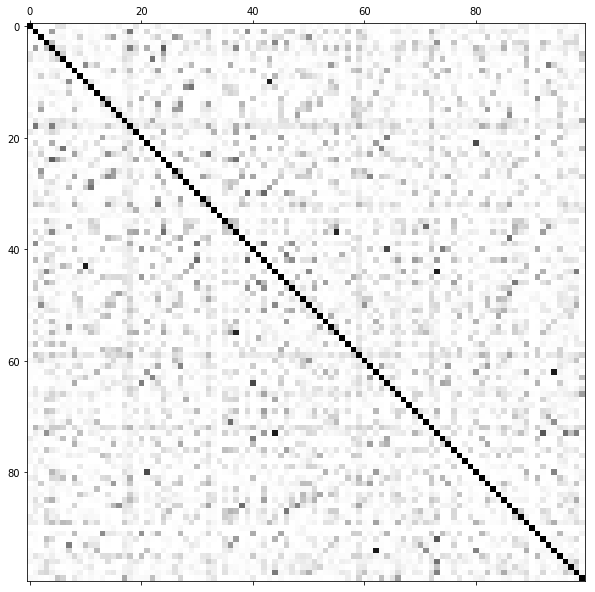

In [140]:
plt.matshow(topic_jaccard_scores, cmap=plt.cm.binary)

In [145]:
def get_most_similar_topic_pairs(topic_sim_scores, top_n=None, threshold=0.7):
    np.fill_diagonal(topic_sim_scores, 0)
    num_topics = topic_sim_scores.shape[0]
    topic_sim_scores = topic_sim_scores.reshape(-1)
    topic_sim_scores = topic_sim_scores
    indices = np.argsort(-topic_sim_scores)
    topic_pairs, topic_scores = [], []
    for idx in indices:
        if threshold is not None and topic_sim_scores[idx] < threshold:
            break
        if top_n is not None and len(topic_pairs) == top_n:
            break
        topic_1, topic_2 = idx // num_topics, idx % num_topics
        if topic_2 > topic_1:
            continue
        topic_pairs.append((topic_1, topic_2))
        topic_scores.append(topic_similarities[idx])
    return topic_pairs, topic_scores

[autoreload of models.lda failed: Traceback (most recent call last):
  File "/home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 661, in exec_module
  File "<frozen importlib._bootstrap_external>", line 767, in get_code
  File "<frozen importlib._bootstrap_external>", line 727, in source_to_code
  File "<frozen importlib._bootstrap>", lin

In [229]:
for topic_1, topic_2 in get_most_similar_topic_pairs(topic_jaccard_scores, top_n=10, threshold=None):
    m.print_topics([topic_1, topic_2])
    print(topic_jaccard_scores[topic_1, topic_2])
    print('\n')

Topic #94: 0.057*"cell" + 0.023*"gene" + 0.019*"dna" + 0.012*"human" + 0.012*"genome" + 0.012*"genetic" + 0.010*"protein" + 0.009*"mouse" + 0.008*"cancer" + 0.008*"bacteria"
Topic #62: 0.025*"drug" + 0.024*"patient" + 0.021*"health" + 0.016*"medical" + 0.015*"disease" + 0.013*"doctor" + 0.012*"cancer" + 0.011*"treatment" + 0.010*"death" + 0.010*"year"
0.162711864407


Topic #73: 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"
Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"
0.160787530763


Topic #43: 0.028*"quantum" + 0.020*"theory" + 0.018*"physics" + 0.015*"particle" + 0.013*"universe" + 0.011*"physicist" + 0.010*"wave" + 0.010*"field" + 0.009*"hole" + 0.009*"state"
Topic #10: 0.051*"light" + 0.019*"laser" + 0.015*"electron" 

In [231]:
for topic_1, topic_2 in get_most_similar_topic_pairs(m.topic_doc_similarities, top_n=10, threshold=None):
    m.print_topics([topic_1, topic_2])
    print(m.topic_doc_similarities[topic_1, topic_2])
    print('\n')

Topic #55: 0.010*"day" + 0.009*"back" + 0.007*"hand" + 0.006*"run" + 0.006*"head" + 0.005*"sit" + 0.005*"begin" + 0.005*"walk" + 0.005*"hour" + 0.005*"man"
Topic #37: 0.015*"life" + 0.014*"family" + 0.013*"year" + 0.012*"friend" + 0.011*"day" + 0.011*"people" + 0.011*"live" + 0.010*"home" + 0.010*"man" + 0.008*"house"
0.390537260822


Topic #24: 0.011*"book" + 0.010*"write" + 0.010*"century" + 0.010*"world" + 0.008*"history" + 0.007*"great" + 0.007*"man" + 0.005*"modern" + 0.005*"year" + 0.004*"life"
Topic #4: 0.021*"people" + 0.006*"thing" + 0.006*"feel" + 0.006*"fact" + 0.005*"human" + 0.005*"point" + 0.005*"world" + 0.005*"question" + 0.005*"person" + 0.005*"bad"
0.307336128336


Topic #73: 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"
Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 

In [233]:
for topic_1, topic_2 in get_most_similar_topic_pairs(m.topic_word_similarities, top_n=10, threshold=None):
    m.print_topics([topic_1, topic_2])
    print(m.topic_word_similarities[topic_1, topic_2])
    print('\n')

Topic #72: 0.015*"thing" + 0.015*"find" + 0.013*"post" + 0.012*"give" + 0.012*"write" + 0.011*"start" + 0.010*"read" + 0.010*"point" + 0.009*"article" + 0.009*"ne"
Topic #18: 0.038*"thing" + 0.026*"people" + 0.018*"lot" + 0.013*"start" + 0.011*"year" + 0.010*"big" + 0.009*"problem" + 0.009*"back" + 0.009*"happen" + 0.009*"talk"
0.650996


Topic #42: 0.068*"company" + 0.017*"year" + 0.014*"employee" + 0.014*"million" + 0.011*"business" + 0.010*"executive" + 0.010*"billion" + 0.009*"accord" + 0.008*"firm" + 0.007*"ceo"
Topic #39: 0.050*"company" + 0.042*"startup" + 0.023*"founder" + 0.016*"investor" + 0.014*"tech" + 0.014*"valley" + 0.013*"start" + 0.012*"silicon" + 0.012*"business" + 0.010*"money"
0.615778


Topic #18: 0.038*"thing" + 0.026*"people" + 0.018*"lot" + 0.013*"start" + 0.011*"year" + 0.010*"big" + 0.009*"problem" + 0.009*"back" + 0.009*"happen" + 0.009*"talk"
Topic #4: 0.021*"people" + 0.006*"thing" + 0.006*"feel" + 0.006*"fact" + 0.005*"human" + 0.005*"point" + 0.005*"world

In [166]:
# Basic idea: Topics that are slightly similar to lots of other topics (consistent, light-but-not-white line on similarity matrix)
# are not that interesting. Usually generic topics. Unsure if this idea is generalizable to different corpuses.
def get_top_topics_from_similarities(topic_jaccard_scores):
    jaccard_medians = np.median(topic_jaccard_scores, axis=0)
    top_indices = np.argsort(-jaccard_medians)
    return top_indices

In [167]:
for top_id in get_top_topics_from_similarities(topic_jaccard_scores):
    m.print_topics(top_id)

Topic #59: 0.020*"system" + 0.011*"problem" + 0.008*"change" + 0.008*"require" + 0.008*"design" + 0.008*"approach" + 0.006*"large" + 0.006*"level" + 0.006*"process" + 0.005*"provide"
Topic #72: 0.015*"thing" + 0.015*"find" + 0.013*"post" + 0.012*"give" + 0.012*"write" + 0.011*"start" + 0.010*"read" + 0.010*"point" + 0.009*"article" + 0.009*"ne"
Topic #18: 0.038*"thing" + 0.026*"people" + 0.018*"lot" + 0.013*"start" + 0.011*"year" + 0.010*"big" + 0.009*"problem" + 0.009*"back" + 0.009*"happen" + 0.009*"talk"
Topic #66: 0.033*"google" + 0.032*"computer" + 0.027*"technology" + 0.019*"machine" + 0.018*"human" + 0.014*"system" + 0.013*"world" + 0.012*"ai" + 0.010*"year" + 0.010*"robot"
Topic #4: 0.021*"people" + 0.006*"thing" + 0.006*"feel" + 0.006*"fact" + 0.005*"human" + 0.005*"point" + 0.005*"world" + 0.005*"question" + 0.005*"person" + 0.005*"bad"
Topic #51: 0.024*"price" + 0.024*"sell" + 0.023*"company" + 0.022*"market" + 0.019*"buy" + 0.018*"business" + 0.016*"product" + 0.015*"pay" +

In [169]:
plotly.offline.iplot([go.Histogram(x=topic_jaccard_scores[66])])

# Similar articles

<h2> Javascript stuff </h2>

In [77]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [79]:
%%javascript
element.append("<div id='chart1'>something</div>");

<IPython.core.display.Javascript object>

# Clusters

In [242]:
m = pickle.load(open('data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

In [41]:
def cluster_topics_afp(model):
    topic_sims = np.copy(m.topic_doc_similarities)
    np.fill_diagonal(topic_sims, 1)
#     max_sim = np.max(topic_sims)
#     topic_sims = topic_sims * 0.8 / max_sim
#     topic_dists = 1 - topic_sims
#     np.fill_diagonal(topic_dists, 0)
    cluster_model = AffinityPropagation(affinity='precomputed')#(eps=0.5, min_samples=2, metric='precomputed')
    labels = cluster_model.fit_predict(topic_sims)
    return labels

In [97]:
def cluster_topics_spectral(model):
    topic_sims = np.copy(m.topic_jaccard_similarities)
    np.fill_diagonal(topic_sims, 1)
#     max_sim = np.max(topic_sims)
#     topic_sims = topic_sims * 0.8 / max_sim
    cluster_model = SpectralClustering(affinity='precomputed', n_clusters=15)#(eps=0.5, min_samples=2, metric='precomputed')
    labels = cluster_model.fit_predict(topic_sims)
    return labels

In [98]:
def print_topic_clusters(m, cluster_labels):
    label_index_mapping = defaultdict(list)
    for index, label in enumerate(cluster_labels):
        label_index_mapping[label].append(index)
    for label, indices in label_index_mapping.items():
        print('Cluster %d----------------------------------' % label)
        for index in indices:
            print('Topic #%d: %s' % (index, m.model.print_topic(index)))
        print('\n')

In [100]:
print_topic_clusters(m, cluster_topics_spectral(m))

Cluster 0----------------------------------
Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"
Topic #73: 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"
Topic #98: 0.069*"datum" + 0.042*"user" + 0.039*"information" + 0.022*"data" + 0.022*"privacy" + 0.022*"access" + 0.017*"service" + 0.011*"internet" + 0.010*"company" + 0.010*"provide"


Cluster 1----------------------------------
Topic #13: 0.030*"stack" + 0.028*"instruction" + 0.022*"register" + 0.021*"address" + 0.021*"code" + 0.017*"call" + 0.015*"memory" + 0.010*"byte" + 0.010*"program" + 0.010*"function"
Topic #14: 0.047*"windows" + 0.042*"linux" + 0.039*"system" + 0.029*"kernel" + 0.027*"microsoft" + 0.020*"os" + 0.014*"run" + 0.013*"boot" + 0.012*"user" + 0.012*"driver"
T

In [96]:
print_topic_clusters(m, cluster_topics_spectral(m))

Cluster 0----------------------------------
Topic #13: 0.030*"stack" + 0.028*"instruction" + 0.022*"register" + 0.021*"address" + 0.021*"code" + 0.017*"call" + 0.015*"memory" + 0.010*"byte" + 0.010*"program" + 0.010*"function"
Topic #20: 0.050*"int" + 0.049*"return" + 0.034*"function" + 0.026*"const" + 0.022*"void" + 0.021*"struct" + 0.021*"null" + 0.018*"type" + 0.017*"template" + 0.014*"char"
Topic #40: 0.030*"function" + 0.022*"string" + 0.019*"return" + 0.017*"variable" + 0.015*"code" + 0.014*"match" + 0.014*"expression" + 0.011*"list" + 0.011*"def" + 0.010*"call"
Topic #45: 0.023*"datum" + 0.021*"memory" + 0.020*"byte" + 0.019*"file" + 0.019*"bit" + 0.017*"size" + 0.011*"hash" + 0.011*"key" + 0.010*"set" + 0.010*"buffer"
Topic #58: 0.034*"thread" + 0.033*"process" + 0.019*"lock" + 0.017*"call" + 0.015*"event" + 0.014*"queue" + 0.014*"task" + 0.013*"run" + 0.010*"wait" + 0.010*"function"
Topic #64: 0.066*"type" + 0.049*"object" + 0.045*"class" + 0.034*"method" + 0.020*"string" + 0.

In [95]:
print_topic_clusters(m, cluster_topics_spectral(m))

Cluster 0----------------------------------
Topic #13: 0.030*"stack" + 0.028*"instruction" + 0.022*"register" + 0.021*"address" + 0.021*"code" + 0.017*"call" + 0.015*"memory" + 0.010*"byte" + 0.010*"program" + 0.010*"function"
Topic #14: 0.047*"windows" + 0.042*"linux" + 0.039*"system" + 0.029*"kernel" + 0.027*"microsoft" + 0.020*"os" + 0.014*"run" + 0.013*"boot" + 0.012*"user" + 0.012*"driver"
Topic #52: 0.017*"pi" + 0.017*"board" + 0.014*"usb" + 0.014*"chip" + 0.012*"power" + 0.012*"hardware" + 0.011*"card" + 0.011*"km" + 0.010*"device" + 0.010*"controller"
Topic #54: 0.030*"design" + 0.012*"build" + 0.009*"wall" + 0.008*"building" + 0.007*"part" + 0.007*"small" + 0.006*"room" + 0.006*"shape" + 0.006*"material" + 0.006*"create"
Topic #77: 0.028*"memory" + 0.025*"cpu" + 0.024*"core" + 0.023*"intel" + 0.022*"performance" + 0.020*"cache" + 0.019*"processor" + 0.018*"chip" + 0.015*"op" + 0.014*"gpu"
Topic #84: 0.047*"device" + 0.019*"phone" + 0.015*"camera" + 0.011*"battery" + 0.011*"lap

# 2-D embeddings

In [11]:
m = pickle.load(open('data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

In [11]:
def transform_similarity_matrix(model, use_word_sims=False):
    if use_word_sims:
        topic_sims = model.topic_word_similarities
    else:
        topic_sims = model.topic_doc_similarities
    np.fill_diagonal(topic_sims, 0)
    max_sim = np.max(topic_sims)
    topic_sims = topic_sims * 0.8 / max_sim
    np.fill_diagonal(topic_sims, 1)
    if use_word_sims:
        model.topic_word_similarities = topic_sims
    else:
        model.topic_doc_similarities = topic_sims


In [151]:
m.init_topic_similarity_matrices()
transform_similarity_matrix(m)

In [17]:
def coordinates_from_similarity(model, use_word_sims=False):
    if use_word_sims:
        topic_sims = np.copy(model.topic_word_similarities)
    else:
        topic_sims = np.copy(model.topic_doc_similarities)
    topic_dists = 1 - topic_sims
    np.fill_diagonal(topic_sims, 1)
    return MDS(dissimilarity='precomputed').fit_transform(topic_dists)

In [25]:
coords = coordinates_from_similarity(m)

In [26]:
x, y = coords[:, 0], coords[:, 1]
text = [m.model.print_topic(i) for i in range(len(coords))]

In [28]:
point_trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    text = text
)
py.iplot([point_trace])

## Graph viz

In [9]:
m = pickle.load(open('data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

INFO:summa.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [12]:
m.init_topic_similarity_matrices()
transform_similarity_matrix(m)

In [13]:
edge_indices = np.where(m.topic_doc_similarities > 0.3)

In [14]:
edge_x, edge_y = [], []

In [15]:
edge_traces = []

In [18]:
coords = coordinates_from_similarity(m)

In [19]:
x, y = coords[:, 0], coords[:, 1]
text = [m.model.print_topic(i) for i in range(len(coords))]

In [20]:
for t1, t2 in zip(edge_indices[0], edge_indices[1]):
    if t1 == t2:
        continue
    t1_coords, t2_coords = coords[t1], coords[t2]
    edge_trace = go.Scatter(
        x = [t1_coords[0], t2_coords[0]],
        y = [t1_coords[1], t2_coords[1]],
        line=go.Line(width=0.5,color='#888'),
        mode='lines',
        hoverinfo='none'
    )
    edge_traces.append(edge_trace)
#     break

In [21]:
point_trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    text = text
)
py.iplot(edge_traces + [point_trace])

In [60]:
m = pickle.load(open('data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

In [61]:
topic_similarities = np.copy(m.topic_doc_similarities)
topic_similarities[np.where(topic_similarities < 0.15)] = 0
np.fill_diagonal(topic_similarities, 0)

In [62]:
topic_graph = nx.from_numpy_matrix(topic_similarities * 50)

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/matplotlib/__init__.py:917: UserWarning:

axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/matplotlib/rcsetup.py:152: UserWarning:

axes.hold is deprecated, will be removed in 3.0



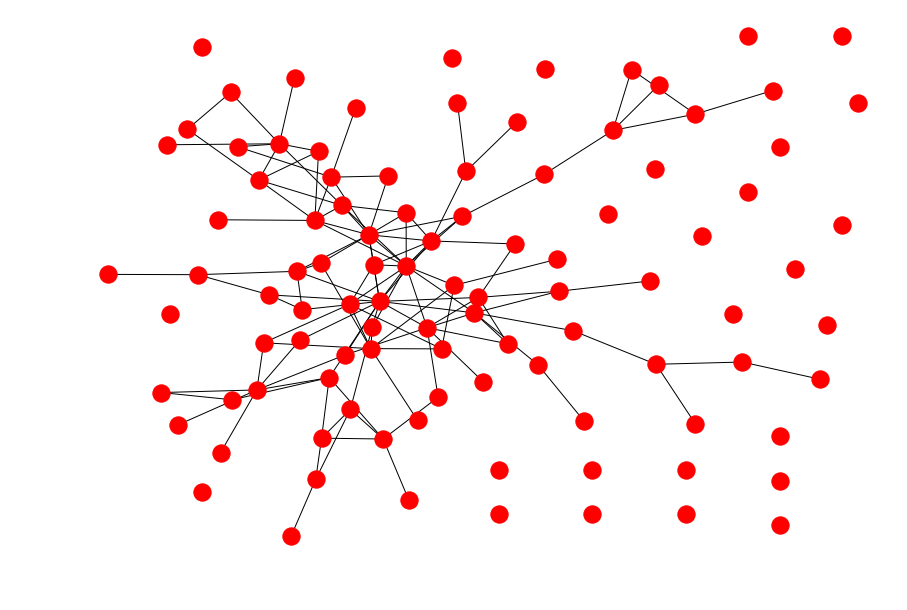

In [65]:
nx.draw_graphviz(topic_graph, prog='neato')

# Topic intersection

In [128]:
m.article_topic_matrix[:, 2].sum(axis=1).shape

AxisError: axis 1 is out of bounds for array of dimension 1

In [145]:
m.show_similar_topics(44)

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"

Topics similar to topic #44---------------------------
Topic #73 (0.29): 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"
Topic #98 (0.21): 0.069*"datum" + 0.042*"user" + 0.039*"information" + 0.022*"data" + 0.022*"privacy" + 0.022*"access" + 0.017*"service" + 0.011*"internet" + 0.010*"company" + 0.010*"provide"
Topic #3 (0.19): 0.013*"group" + 0.013*"public" + 0.012*"political" + 0.010*"state" + 0.010*"member" + 0.010*"policy" + 0.010*"campaign" + 0.009*"president" + 0.009*"party" + 0.009*"government"
Topic #50 (0.15): 0.036*"security" + 0.029*"attack" + 0.018*"vulnerability" + 0.014*"exploit" + 0.012*"hacker" + 0.012*"password" + 0.011*"attacker" + 0.011*"hack" + 0.010*"find" + 

In [146]:
m.show_topic_articles([44, 98])

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"
Topic #98: 0.069*"datum" + 0.042*"user" + 0.039*"information" + 0.022*"data" + 0.022*"privacy" + 0.022*"access" + 0.017*"service" + 0.011*"internet" + 0.010*"company" + 0.010*"provide"
---------------------------------------------------------------------
Article #10615250 - https://www.washingtonpost.com/news/the-switch/wp/2015/11/20/why-its-so-hard-to-keep-up-with-how-the-u-s-government-is-spying-on-its-own-people/
Why its so hard to keep up with how the U.S. gov't is spying on its own people

Since 2013, Americans have gained immense insight about how the government conducts digital spying programs, largely thanks to the revelations made by former security contractor Edward Snowden. But a new report shows it's really hard to keep track of all the ways the United States is snooping on its 

---------------------------------------------------------------------
Article #12037042 - https://www.fbi.gov/news/pressrel/press-releases/statement-by-fbi-director-james-b.-comey-on-the-investigation-of-secretary-hillary-clintons-use-of-a-personal-e-mail-system
FBI Statement on Clinton Email System

Remarks prepared for delivery at press briefing.

Good morning. I’m here to give you an update on the FBI’s investigation of Secretary Clinton’s use of a personal e-mail system during her time as Secretary of State.

After a tremendous amount of work over the last year, the FBI is completing its investigation and referring the case to the Department of Justice for a prosecutive decision. What I would like to do today is tell you three things: what we did; what we found; and what we are rec


---------------------------------------------------------------------
Article #12111413 - http://www.theguardian.com/politics/2016/jul/16/justice-department-freedom-of-information-computer-system?CMP=s

---------------------------------------------------------------------
Article #11465978 - http://www.buzzfeed.com/peteraldhous/spies-in-the-skies
Maps Showing Where FBI Planes Are Watching from Above

America is being watched from above. Government surveillance planes routinely circle over most major cities — but usually take the weekends off.

Each weekday, dozens of U.S. government aircraft take to the skies and slowly circle over American cities. Piloted by agents of the FBI and the Department of Homeland Security (DHS), the planes are fitted with high-resolution video cameras, often working with “augmented reality” software that can superimpose onto the video images everything from 


---------------------------------------------------------------------
Article #10364477 - https://www.washingtonpost.com/world/national-security/in-a-first-chinese-hackers-are-arrested-at-the-behest-of-the-us-government/2015/10/09/0a7b0e46-6778-11e5-8325-a42b5a459b1e_story.html
Chinese hackers are arr

---------------------------------------------------------------------
Article #11433839 - https://www.theguardian.com/technology/2016/apr/05/tinder-swipebuster-spy-on-users-privacy-dating-app
New website lets anyone spy on Tinder users

Tinder isn’t as private as many of its users think, and a new website which aims to exploit that is causing concern among users of the dating app.

Swipebuster promises to let Tinder users find out whether people they know have an account on the dating app, and even stalk them down to their last known location.

Facebook Twitter Pinterest A screenshot of the Swipebuster website. Photograph: Swipebuster

The website charges $4.99 (£3.50) to let someone see whether the target is using Tinder, a


---------------------------------------------------------------------
Article #12302085 - http://www.nytimes.com/2016/08/17/us/shadow-brokers-leak-raises-alarming-question-was-the-nsa-hacked.html
Shadow Brokers Leak Raises Question of whether the N.S.A. was Hacke

---------------------------------------------------------------------
Article #10862865 - https://motherboard.vice.com/read/the-fbis-unprecedented-hacking-campaign-targeted-over-a-thousand-computers
FBI's 'Unprecedented' Hacking Campaign Targeted Over a Thousand Computers

In the summer of 2015, two men from New York were charged with online child pornography crimes. The site the men allegedly visited was a Tor hidden service, which supposedly would protect the identity of its users and server location. What made the case stand out was that the Federal Bureau of Investigation (FBI) had used a hacking tool to identify the IP addresses of the individuals.

The case received some media attention, and snippets of information about other, related arrests started to spr


---------------------------------------------------------------------
Article #10356985 - https://www.eff.org/deeplinks/2015/10/victory-california-gov-brown-signs-calecpa-requiring-police-get-warrant-accessing
Gov. Brown Si

---------------------------------------------------------------------
Article #10829529 - http://www.economist.com/news/christmas-specials/21683975-man-who-made-edward-snowden-inevitable-black-chamber
The man who made Edward Snowden inevitable

IT WAS a shocking disclosure that made headlines around the world. An American intelligence professional revealed the existence of a secret American bureau, which obtained, decoded and read the private messages of nearly 20 foreign governments. He disclosed methods of surveillance and subterfuge, describing a clandestine world of pilfered telegrams, forged wax seals and invisible inks. Laws had been broken and the privacy of many intruded upon. Telecommunications companies had co-operated secret


---------------------------------------------------------------------
Article #11323354 - https://www.ftc.gov/news-events/press-releases/2016/03/ftc-issues-warning-letters-app-developers-using-silverpush-code
FTC Issues Warning Letters to App Developer

---------------------------------------------------------------------
Article #11340537 - https://blog.torproject.org/blog/statement-tor-project-software-integrity-and-apple
A Statement from The Tor Project on Software Integrity and Apple

The Tor Project exists to provide privacy and anonymity for millions of people, including human rights defenders across the globe whose lives depend on it. The strong encryption built into our software is essential for their safety.

In an age when people have so little control over the information recorded about their lives, we believe that privacy is worth fighting for.

We therefore stand with Apple to defend strong encryption and to oppose government pressure to weaken it. We will never back


---------------------------------------------------------------------
Article #11175496 - https://www.eff.org/press/releases/eff-urges-appeals-court-allow-wikimedia-and-others-fight-nsa-surveillance
EFF Urges Appeals Court to Allow Wikimedia and Others to F

id                                              title  \
233106  10615250  Why its so hard to keep up with how the U.S. g...   
275315  10304864                                  Edwardsnowden.com   
153466  11246429  FBI quietly changes its privacy rules for acce...   
152923  11251333  Obama Administration Set to Expand Sharing of ...   
161974  11179252  Obama Administration Set to Expand Sharing of ...   
93571   11753395  FBI Wants to Exempt Its Biometric Database fro...   
282784  10250097  George W. Bush Made Retroactive N.S.A. Fix Aft...   
66690   11992358  NSA tracking cellphone locations worldwide, Sn...   
94112   11748746  Snowden calls for whistleblower shield after c...   
83850   11837578  Snowden Tried to Tell NSA About Surveillance C...   
135036  11400686  Report: FBI moves to interview Clinton over em...   
229998  10638705  NSA to shut down bulk phone surveillance progr...   
207965  10812888  Companies to face criminal offence if they tip...   
190110  10960940      How the CIA Helped Produce 'Zero Dark Thirty'   
271545  10332851  Edward Snowden interview: 'Smartphones can be ...   
107129  11636932  Who Has Your Back? Government Data Requests 20...   
269968  10344712  Former NSA Chief Disagrees with Current NSA Ch...   
16123   12429748  German Federal Intelligence Service BND Violat...   
277962  10285918  Edward Snowden promotes global treaty to curta...   
12628   12462010  Inside the fight to reveal the CIA's torture s...   
35838   12258353  90-year-old Cryptanalytic Efforts Must Stay Se...   
159057  11202624  Snooper's charter to extend police access to p...   
158627  11205966  UK government pushing ahead with surveillance ...   
278708  10279853  From Radio to Porn, British Spies Track Web Us...   
234404  10604259  File Says N.S.A. Found Way to Replace Email Su...   
245856  10518304     MI5 'secretly collected phone data' for decade   
203782  10850485  'Snooper's charter' will cost British lives, M...   
106056  11646685  Archivist Wont Call Torture Report a Permanent...   
217914  10731847  Did You Really Agree to That? The Evolution of...   
117466  11548689  UK intel agencies spy indiscriminately on mill...   
...          ...                                                ...   
2032    12559215   Yahoo says at least 500M accounts hacked in 2014   
126642  11473696  Judge Who Authorized Police Search of Privacy ...   
14332   12443807  The privacy wars are about to get a whole lot ...   
142299  11340537  A Statement from The Tor Project on Software I...   
162448  11175496  EFF Urges Appeals Court to Allow Wikimedia and...   
88866   11795465  You cant replace your face, says face recognition   
26824   12335168  Browsing your website does not mean I want you...   
147606  11293949  Apple files final response in San Bernardino i...   
3381    12547130  Google backs off on previously announced Allo ...   
210663  10789987  Operation Easy Chair: How a Company in Holland...   
145848  11308005  Denver Police Caught Misusing Databases Got Li...   
120913  11521409     Hacking Team's 'Illegal' Latin American Empire   
259354  10421736  Apple tells U.S. judge 'impossible' to unlock ...   
55338   12088419      The Tor Project Elects New Board of Directors   
95325   11737636  If you care about privacy, you should not use ...   
61758   12036170               Silent Circle removes warrant canary   
99657   11701728  UC students suit claims Google scanned account...   
35769   12259024  Google employees have enjoyed revolving door d...   
27851   12325140       Data points that Facebook uses to target ads   
153243  11248320  One of the FBIs Major Claims in the iPhone Cas...   
161043  11186902  Apples Privacy Fight Tests Relationship with W...   
213876  10764037  TSA Doesnt Care That Its Luggage Locks Have Be...   
261085  10410449                                     MEGA is genius   
81608   11858962     Microsoft Finds Cancer Clues in Search Queries   
35195   12263238  PatientBank (YC S16)

In [147]:
m.show_topic_articles([44])

Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"
---------------------------------------------------------------------
Article #10304864 - https://edwardsnowden.com/
Edwardsnowden.com

Who Is Edward Snowden?

Edward Snowden is a 31 year old US citizen, former Intelligence Community officer and whistleblower. The documents he revealed provided a vital public window into the NSA and its international intelligence partners’ secret mass surveillance programs and capabilities. These revelations generated unprecedented attention around the world on privacy intrusions and digital security, leading to a global debate on the issue.

Snowden worked in various roles within the US Intel


---------------------------------------------------------------------
Article #11748746 - http://www.theguardian.com/us-news/2016/may/22/snowden-whistleblower-prote

---------------------------------------------------------------------
Article #12104279 - http://www.npr.org/sections/parallels/2016/07/15/486198380/congress-releases-28-pages-that-looks-for-saudi-links-to-sept-11-hijackers
Congress Releases '28 Pages' That Looks for Saudi Links to Sept. 11 Hijackers

Congress Releases '28 Pages' That Looks For Saudi Links To Sept. 11 Hijackers

Enlarge this image toggle caption John Raoux/AP John Raoux/AP

Congress on Friday released the "28 pages," a previously classified document that examined possible connections between the Saudi government and the Sept. 11 hijackers.

The document — which actually contains 29 pages — had taken on a life of its own, prompting frequent speculation about its contents, though only a limited number of government official


---------------------------------------------------------------------
Article #10304683 - http://www.wired.com/2015/09/campaign-help-surveillance-agents-quit-nsa-gchq/
New Campaign to Help Surveilla

---------------------------------------------------------------------
Article #10778642 - https://edri.org/santa-claus-confirms-nsa-attack-on-naughty-or-nice-database/
Santa Claus Confirms NSA Attack on Naughty or Nice Database

By Joe McNamee

A press conference was organised this morning on behalf of Mr Santa Claus. At the conference, a spokes–elf confirmed that there had been repeated attempts to hack the “naughty or nice (NON)” database. The NON-database was thought to be used by Mr Claus to keep records of young inhabitants of planet earth, in order to set gift-giving priorities on 6, 24 and 25 December each year.

Mr Claus’ spokes-elf stressed that the security of the database was not compromised in any wa


---------------------------------------------------------------------
Article #10825580 - https://www.eff.org/deeplinks/2015/12/encryption-balance-2015-review
Encryption in the Balance: 2015 in Review

If you’ve spent any time reading about encryption this year, you know we’r



---------------------------------------------------------------------
Article #11643246 - https://www.techdirt.com/articles/20160505/00383034349/fbi-harassing-core-tor-developer-demanding-she-meet-with-them-refusing-to-explain-why.shtml
FBI Harassing Core Tor Developer, Demand Meeting, but Refusing to Explain Why

Word got to my lawyer in the US, who decided to call FBI Special Agent Mark Burnett, on that Friday, saying that he represented me and my family. Burnett said the FBI simply wanted to ask me some questions. My lawyer responded by stating that, as my invoked representation, all questions should be directed to him rather than to me or my family. The agent agreed, paused while some muffled male voices were heard in the background, and asked to call back in five minutes.



Five minutes later, Burne


---------------------------------------------------------------------
Article #10531046 - http://www.nature.com/nature/journal/v527/n7576/full/527035a.html
Why Torture Doesn't Wor

By Chris Madsen, Head of Global Law Enforcement, Security, and Safety



As part of our ongoing commitment to transparency, Yahoo is announcing today the public disclosure of three National Security Letters (NSLs) that it received from the Federal Bureau of Investigation (FBI). This marks the first time any company has been able to publicly acknowledge receiving an NSL as a result of the reforms of the USA Freedom Act.

We’re able to disclose details of these NSLs today because, with the enact


---------------------------------------------------------------------
Article #11859018 - https://restorethe4th.com/victory-in-california-santa-clara-count-votes-to-adopt-landmark-surveillance-technology-ordinance/
Santa Clara County Votes to Adopt Surveillance Technology Ordinance

Victory in California: Santa Clara County Votes to Adopt Landmark Surveillance Technology Ordinance

By Zaki Manian, National Board Secretary and Chair of RT4 San Francisco Bay Area

Today, an idea that was born in 

---------------------------------------------------------------------
Article #10417551 - http://www.reuters.com/article/2015/10/19/us-usa-bitcoin-silkroad-idUSKCN0SD2IA20151019
Ex-U.S. agent gets over six years for Bitcoin theft in Silk Road probe

A Bitcoin logo is displayed at the Bitcoin Center New York City in New York's financial district July 28, 2015.

SAN FRANCISCO (Reuters) - A former U.S. federal agent was sentenced to 78 months in prison on Monday for stealing bitcoins during the government's investigation of Silk Road and for secretly soliciting payment from the operator of the online black market for information on its probe.

Carl Force, a former U.S. Drug Enforcement Administration agent, admitted to charges of extortion, mo


---------------------------------------------------------------------
Article #10774152 - http://arstechnica.com/tech-policy/2015/12/cock-li-e-mail-server-seized-by-german-authorities-admin-announces/
Cock.li e-mail server seized by German authori

Article #11697122 - http://www.politico.com/story/2016/05/elon-musk-rocket-defense-223161?href
How Elon Musk exposed billions in questionable Pentagon spending

The entrenched contractor, a joint operation of Boeing and Lockheed Martin called the United Launch Alliance, has conducted 106 space launches all but flawlessly, but the cost for each is more than $350 million. | Getty How Elon Musk exposed billions in questionable Pentagon spending Ten years after a joint operation of Boeing and Lockheed Martin was born, the FTC’s direst warnings have come true, along with outcomes even the skeptics did not predict.

Elon Musk’s SpaceX had to sue before it


---------------------------------------------------------------------
Article #12292703 - https://www.riskbasedsecurity.com/2016/08/the-shadow-brokers-lifting-the-shadows-of-the-nsas-equation-group/
Lifting the Shadows of the NSAs Equation Group

By

The Beginning (August 15)

The Dust Has Settled, Or Has It? (August 16)

Vulnerability De

id                                              title  \
275315  10304864                                  Edwardsnowden.com   
94112   11748746  Snowden calls for whistleblower shield after c...   
233106  10615250  Why its so hard to keep up with how the U.S. g...   
83850   11837578  Snowden Tried to Tell NSA About Surveillance C...   
135036  11400686  Report: FBI moves to interview Clinton over em...   
282784  10250097  George W. Bush Made Retroactive N.S.A. Fix Aft...   
153466  11246429  FBI quietly changes its privacy rules for acce...   
229998  10638705  NSA to shut down bulk phone surveillance progr...   
190110  10960940      How the CIA Helped Produce 'Zero Dark Thirty'   
152923  11251333  Obama Administration Set to Expand Sharing of ...   
269968  10344712  Former NSA Chief Disagrees with Current NSA Ch...   
161974  11179252  Obama Administration Set to Expand Sharing of ...   
12628   12462010  Inside the fight to reveal the CIA's torture s...   
106056  11646685  Archivist Wont Call Torture Report a Permanent...   
35838   12258353  90-year-old Cryptanalytic Efforts Must Stay Se...   
77929   11892334  Clinton approved CIA drone assassinations with...   
191810  10947366  NSA Chief Stakes Out Pro-Encryption Position, ...   
276357  10296606  Latest Snowden Doc Shows NSA Spied on German I...   
236146  10591329  John McCain wants to outlaw encryption that th...   
213645  10766171  Juniper hack has U.S. fearing foreign infiltra...   
138680  11372264               How Clintons email scandal took root   
207454  10817463  NSA Cheerleaders Discover Value of Privacy Onl...   
16752   12422713  FBI: Hillary Clinton Didn't Know 'C' in Emails...   
234774  10601265  Baseless Calls to Expand Surveillance Fit Fami...   
277962  10285918  Edward Snowden promotes global treaty to curta...   
237727  10580412  Times Pulls Article Blaming Encryption in Pari...   
483     12573479  Probe of leaked U.S. NSA hacking tools examine...   
243238  10537801   Why Obama did not stop NSA domestic surveillance   
263280  10393860  Federal Whistleblower Investigator Fired After...   
129498  11449099  The Obama Administration Has Embraced Legal Th...   
...          ...                                                ...   
186989  10982220                     Trying to interview Larry Page   
239340  10567333           Thursday Beirut suicide bombings kill 43   
252284  10469375    USDA Scientist Punished for Pollinator Research   
277467  10289490              Two Forgotten Architects of Silk Road   
80131   11870302  Reviewing Microsoft's Automatic Insertion of T...   
272020  10329644  The nuke detectives  New ways to detect covert...   
84363   11832512           Verifiable Credentials on the Blockchain   
121717  11515106  UC Berkeley student questioned, refused servic...   
177445  11059301  Not-so-secret atomic tests: Why the photograph...   
11473   12473827   The careless errors of credit reporting agencies   
233927  10608547  Baffling Web Trackers by Obfuscating Your Move...   
66234   11996031                  GitHub's 2015 Transparency Report   
146122  11305701                      Limitless Worker Surveillance   
223906  10685960  Anonymous Divided: Inside the Two Warring Hack...   
250570  10482033  Kim Dotcom reveals more about his blockchain-i...   
120848  11522024       Kuwait set to enforce DNA testing law on all   
271369  10334087     Users Have Been Betrayed in the Final TPP Deal   
237446  10582276  Microsoft, Once Infested with Security Flaws, ...   
241472  10550043  Did the FBI Pay a University to Attack Tor Users?   
272460  10326171                                Im Stalins daughter   
292082  10184355  A 1985 Essay from a Bulletin Board System Admi...   
117482  11548552  Firms that paid for Clinton speeches have US g...   
97091   11722573  The TSA is a waste of money that doesn't save ...   
241752  10547959  Not So Securus - Massive Hack of 70 Million Pr...   
262739  10397668  TPP could thwart com

In [148]:
m.show_similar_topics(5)

Topic #5: 0.074*"word" + 0.050*"book" + 0.037*"language" + 0.029*"text" + 0.018*"read" + 0.017*"english" + 0.016*"document" + 0.016*"character" + 0.016*"letter" + 0.012*"write"

Topics similar to topic #5---------------------------
Topic #24 (0.18): 0.011*"book" + 0.010*"write" + 0.010*"century" + 0.010*"world" + 0.008*"history" + 0.007*"great" + 0.007*"man" + 0.005*"modern" + 0.005*"year" + 0.004*"life"
Topic #72 (0.16): 0.015*"thing" + 0.015*"find" + 0.013*"post" + 0.012*"give" + 0.012*"write" + 0.011*"start" + 0.010*"read" + 0.010*"point" + 0.009*"article" + 0.009*"ne"
Topic #18 (0.13): 0.038*"thing" + 0.026*"people" + 0.018*"lot" + 0.013*"start" + 0.011*"year" + 0.010*"big" + 0.009*"problem" + 0.009*"back" + 0.009*"happen" + 0.009*"talk"
Topic #59 (0.11): 0.020*"system" + 0.011*"problem" + 0.008*"change" + 0.008*"require" + 0.008*"design" + 0.008*"approach" + 0.006*"large" + 0.006*"level" + 0.006*"process" + 0.005*"provide"
Topic #4 (0.10): 0.021*"people" + 0.006*"thing" + 0.006*"f

In [154]:
m.show_topic_articles([5, 99])

Topic #5: 0.074*"word" + 0.050*"book" + 0.037*"language" + 0.029*"text" + 0.018*"read" + 0.017*"english" + 0.016*"document" + 0.016*"character" + 0.016*"letter" + 0.012*"write"
Topic #99: 0.035*"network" + 0.033*"model" + 0.024*"learning" + 0.024*"neural" + 0.018*"learn" + 0.015*"machine" + 0.014*"deep" + 0.014*"training" + 0.014*"layer" + 0.014*"image"
---------------------------------------------------------------------
Article #11052034 - http://www.wildml.com/deep-learning-glossary/
Deep Learning Glossary

This glossary is work in progress and I am planning to continuously update it. If you find a mistake or think an important term is missing, please let me know in the comments or via email.

Deep Learning terminology can be quite overwhelming to newcomers. This glossary tries to define commonly used terms and link to original references and additional resources to help readers dive deeper into a specific topic.

The boundary between what is Deep Learning vs. “general” Machine Lear


Published: Sun 29 November 2015 In blog.

(This lays the ground work for the next post, which was getting too long to be effective.)

Overfitting

One of the goals of machine learning is generalizability. A model that only works on the exact data it was trained on is effectively useless. Let's say you're tasked with creating a bird-recognition system. If you train a model to recognize pictures of birds, and it gets 100% accuracy on the 130 pictures of 10 classes of birds you showed it, is it a g


---------------------------------------------------------------------
Article #11766063 - https://medium.com/@Terrybroad/autoencoding-blade-runner-88941213abbe
Autoencoding Blade Runner: reconstructing films with artificial neural networks

Technical Background

In the past 12 months, interest in—and the development of — using artificial neural networks for the generation of text, images and sound has exploded. In particular, methods for the generation of images have advanced remarkably in r

---------------------------------------------------------------------
Article #10440066 - http://bertolami.com/index.php?engine=blog&content=posts&detail=randomized-decision-forests
A Gentle Introduction to Randomized Decision Forests

Randomized Decision Forests

Friday, October 23rd, 2015

Over the last decade we've witnessed a transformation in human interfaces brought on largely by advances in machine learning. Automated phone assistants, voice and text translators, self driving cars, and much more, are all reliant on various forms of machine learning.



The randomized decision forest is a machine learning algorithm that's useful for these kinds of tasks. This algorithm gained significant popularity over the last several 


---------------------------------------------------------------------
Article #10448099 - http://karpathy.github.io/2015/10/25/selfie/
What a Deep Neural Network thinks about selfies

Convolutional Neural Networks are great: they recognize things, places and pe

---------------------------------------------------------------------
Article #12472945 - https://medium.com/learning-new-stuff/machine-learning-in-a-year-cdb0b0ebd29c
Machine Learning in a Year

First intro: Hacker News and Udacity

My interest in ml stems back to 2014 when I started reading articles about it on Hacker News. I simply found the idea of teaching machines stuff by looking at data appealing. At the time I wasn’t even a professional developer, but a hobby coder who’d done a couple of small projects.

So I began watching the first few chapters of Udacity’s Supervised Learning course, while also reading all articles I came across on the subject.

This gave me a little bi


---------------------------------------------------------------------
Article #10711951 - http://blog.otoro.net/2015/05/07/creatures-avoiding-planks/
Creatures avoiding planks

Update: This post has been translated to Japanese and Chinese.

Recently I came across a video of a simulation that demonstrates t

In Chinese, the word computer translates directly as electric brain. In Icelandic, a compass is a direction-shower, and a microscope a small-watcher. In Lakota, horse is literally dog of wonder. These neologisms demonstrate the cumulative quality of language, in which we use the known to describe the unknown. “It is by metaphor that language grows,” writes the psychologist Julian Jaynes. “The common reply to the question ‘What is it?’ is, when the reply is difficult or the experience u


---------------------------------------------------------------------
Article #10296505 - http://betterexplained.com/articles/adjective-fallacy/
Avoiding the Adjective Fallacy

You’re reading this, so I’ll assume your English is pretty good. What’s wrong with these phrases?

Old little lady

Red big dog

Vietnamese spicy food

Do you have a logical reason for why they sound strange? Or are they just off?

You probably didn’t think, “In 3rd grade I mastered the Royal Order of Adjectives:

Determiner Obs

id                                              title  \
178305  11052034                             Deep Learning Glossary   
254523  10454261                    Deep learning for NLP resources   
264760  10384279  Convolutional neural networks and feature extr...   
42973   12196388  MNIST Handwritten Digit Classifier  beginner n...   
83643   11840175  What is the difference between deep learning a...   
105208  11654975  Buffalo buffalo Buffalo buffalo buffalo buffal...   
99664   11701665                     Building autoencoders in Keras   
77408   11897072  Basic neural network subroutines (BNNS) API fr...   
34740   12266623                         Top Deep Learning Projects   
285075  10232690  Recurrent Neural Networks Tutorial, Part 1: In...   
81883   11856211  Building powerful image classification models ...   
101478  11686064  TensorFlow  A curated list of dedicated resources   
31657   12292576          The Confusion of Variational Autoencoders   
141741  11345317  Tensorflow Implementation of Deep Visual Analo...   
147343  11296439              FlappyBird hack using Deep Q-Learning   
223707  10687556  Deep neural network written from scratch in Julia   
24940   12351523    Some of the most important deep learning papers   
87326   11808624         TensorFlow  Consise Examples for Beginners   
206177  10830004      Attention and Memory in Deep Learning and NLP   
180742  11029879                               TensorFlow Tutorials   
150494  11269439  Unsupervised Learning with Even Less Supervisi...   
285087  10232595           Artificial Neural Networks for Beginners   
194886  10923677  Voynich Manuscript: word vectors and t-SNE vis...   
189115  10968096            Deep Learning with Spark and TensorFlow   
219720  10717171  Implementing a CNN for Text Classification in ...   
97952   11714895  Google applying to patent deep neural network ...   
27817   12325540        If English were written like Chinese (1999)   
142178  11341706  TensorFlow Implementation of Deep Convolutiona...   
35497   12260853  Image Completion with Deep Learning in TensorFlow   
64447   12009909                Neural Networks in iOS 10 and macOS   
...          ...                                                ...   
46162   12167097          Making Sense of Everything with words2map   
78599   11884934  A Simple Content-Based Recommendation Engine i...   
215574  10750125  Georgia Tech Researchers Demonstrate How the B...   
27326   12330462  Probabilistic Programming and Bayesian Methods...   
210174  10794273  Implementing functional languages: a tutorial ...   
47053   12159824                     Tom Wolfe takes on linguistics   
208700  10806956  When coding style survives compilation: De-ano...   
121028  11520633  Fair use prevails as Supreme Court rejects Goo...   
261096  10410362  Earliest Known Draft of King James Bible Is Fo...   
192692  10940484                                   A Book about Qt5   
60002   12049088  Scrapely: The brains behind Portia, our visual...   
291282  10189259                       Visualizing machine learning   
73962   11925201               Facebook is wrong, text is deathless   
139250  11366943  Show HN: Pytrader  trade cryoptocurrencies aut...   
78173   11889790      Feck: Swearing from the first F to the 21st C   
255165  10449660          An Interactive Guide to Ambiguous Grammar   
110790  11604796                                     Mother Tongues   
262514  10398956                              The Danger of E-Books   
207602  10816112  How brain architecture relates to consciousnes...   
187086  10981682            Google AI beats a pro at the game of Go   
202962  10857624  Google translated Russia to 'Mordor' in 'autom...   
223621  10688201          E-Prime: English without the verb 'to be'   
111946  11594880                      The Secrets of Medieval Fonts   
283449  10244398  Why Are Eight Bits Enough for Deep Neural Netw...   
42074   12204676                 Crack

In [160]:
m.plot_topic([44, 98])

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:113: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jayant/Projects/recurse/hn_analyze/models/lda.py:115: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=30).mean()



Topic #44: 0.026*"government" + 0.017*"agency" + 0.013*"security" + 0.012*"nsa" + 0.012*"surveillance" + 0.011*"fbi" + 0.011*"snowden" + 0.010*"intelligence" + 0.010*"document" + 0.010*"information"
Topic #98: 0.069*"datum" + 0.042*"user" + 0.039*"information" + 0.022*"data" + 0.022*"privacy" + 0.022*"access" + 0.017*"service" + 0.011*"internet" + 0.010*"company" + 0.010*"provide"


## LDAvis

In [10]:
import pyLDAvis.gensim
import gensim

In [11]:
pyLDAvis.enable_notebook()

In [176]:
corpus_csc = gensim.matutils.corpus2csc(m.corpus, num_terms=len(m.corpus.dictionary))

In [182]:
fnames_argsort = np.asarray(list(m.corpus.dictionary.token2id.values()), dtype=np.int_)
term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]

In [177]:
doc_lengths = corpus_csc.sum(axis=0).A.ravel()

In [190]:
vocab = list(m.corpus.dictionary.token2id.keys())

In [191]:
data = {'topic_term_dists': m.model.wordtopics, 'doc_topic_dists': m.article_topic_matrix,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}

In [192]:
topic_vis_data = ldavis.prepare(**data)

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning:

divide by zero encountered in log

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning:

divide by zero encountered in log

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning:

divide by zero encountered in log

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/pyLDAvis/_prepare.py:208: RuntimeWarning:

invalid value encountered in multiply

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/pyLDAvis/_prepare.py:2

In [193]:
ldavis.display(topic_vis_data)

In [173]:
m.model.wordtopics.shape

(100, 37711)

In [171]:
m.corpus.dictionary

In [13]:
corpus = pickle.load(open('data/articles/corpus_ldam_10p_5w_100t', 'rb'))

In [15]:
m = ldamodel.LdaModel.load('./data/articles/ldam_10p_5w_100t')

INFO:gensim.utils:loading LdaModel object from ./data/articles/ldam_10p_5w_100t
INFO:gensim.utils:loading id2word recursively from ./data/articles/ldam_10p_5w_100t.id2word.* with mmap=None
INFO:gensim.utils:setting ignored attribute state to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:loaded ./data/articles/ldam_10p_5w_100t
INFO:gensim.utils:loading LdaModel object from ./data/articles/ldam_10p_5w_100t.state
INFO:gensim.utils:loaded ./data/articles/ldam_10p_5w_100t.state


In [17]:
pyLDAvis.gensim.prepare(m, corpus, corpus.dictionary)

/home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



> /home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/site-packages/pyLDAvis/_prepare.py(402)prepare()
-> topic_coordinates = _topic_coordinates(mds, topic_term_dists, topic_proportion)
(Pdb) c
> /home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/site-packages/pyLDAvis/_prepare.py(421)to_json()
-> return json.dumps(self.to_dict(), cls=NumPyEncoder)
(Pdb) c


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
95     7.574675        1       1  0.140530 -0.051410
23     7.073126        1       2  0.179097  0.054828
90     5.657210        1       3  0.122668  0.000308
54     5.617255        1       4  0.141773  0.050572
34     4.791510        1       5  0.006050 -0.020752
24     3.651559        1       6  0.154179  0.088827
98     3.562002        1       7  0.101903 -0.077808
85     3.061542        1       8  0.001778 -0.095807
68     2.685768        1       9  0.104994  0.043368
28     2.666617        1      10 -0.138286  0.130926
49     2.527692        1      11 -0.191841 -0.069920
70     2.486709        1      12 -0.157163 -0.053988
88     2.271698        1      13 -0.160323  0.066146
58     2.165186        1      14 -0.054717  0.017982
40     2.060740        1      15  0.121384 -0.063884
46     1.787974        1      16  0.088328  0.037199
73     1.774325        1      17  0.063318 -0.072405
81     1.747552        1      18 -0.176976  0.070701
79     1.654231        1      19  0.105873 -0.021000
8      1.621714        1      20  0.006980 -0.096419
53     1.466022        1      21  0.118892 -0.030210
6      1.362410        1      22  0.085801  0.007972
3      1.325404        1      23 -0.014194  0.084415
55     1.262080        1      24  0.015957 -0.139275
56     1.226688        1      25 -0.074516  0.029952
76     1.093856        1      26  0.083360  0.048042
71     0.994903        1      27 -0.007686  0.061533
36     0.994501        1      28 -0.139029  0.095013
59     0.913977        1      29  0.084696 -0.078801
99     0.881771        1      30  0.024773 -0.053246
...         ...      ...     ...       ...       ...
48     0.189197        1      71  0.097714 -0.015565
65     0.180765        1      72  0.072839 -0.000663
18     0.179015        1      73 -0.060610 -0.065309
41     0.163208        1      74 -0.004532 -0.098631
31     0.146252        1      75 -0.032674  0.026943
63     0.116354        1      76 -0.107545 -0.119111
38     0.108729        1      77 -0.089758 -0.026198
51     0.107725        1      78  0.075978  0.011837
47     0.080364        1      79 -0.082645  0.036204
33     0.078598        1      80 -0.051750  0.034250
57     0.077091        1      81 -0.092576  0.084658
14     0.058994        1      82  0.023441 -0.059711
26     0.055435        1      83  0.009401  0.073418
15     0.054853        1      84 -0.015310 -0.045579
74     0.045799        1      85  0.040090  0.088879
87     0.042981        1      86 -0.140838  0.006323
83     0.042001        1      87 -0.050514 -0.029309
42     0.037203        1      88 -0.047960 -0.051446
66     0.029638        1      89  0.060640  0.015212
9      0.026029        1      90  0.101190  0.025290
96     0.025884        1      91 -0.134042  0.032322
78     0.024500        1      92 -0.051587 -0.063827
67     0.022123        1      93 -0.098874 -0.137487
37     0.019156        1      94 -0.034635  0.089185
64     0.018325        1      95 -0.039029  0.015471
1      0.015515        1      96 -0.065540  0.098024
77     0.005259        1      97 -0.065237  0.061793
17     0.001189        1      98 -0.059112  0.003817
86     0.001189        1      99  0.076032 -0.015552
0      0.001189        1     100  0.010089 -0.047720

[100 rows x 5 columns], topic_info=       Category        Freq          Term       Total  loglift  logprob
term                                                                   
26427   Default  172.000000           who  172.000000  30.0000  30.0000
28509   Default  143.000000          year  143.000000  29.0000  29.0000
11582   Default  159.000000        people  159.000000  28.0000  28.0000
19857   Default   87.000000          code   87.000000  27.0000  27.0000
8882    Default   94.000000        system   94.000000  26.0000  26.0000
20672   Default   59.000000    university   59.000000  25.0000  25.0000
26287   Default   

In [15]:
ldavis_obj = pyldavis.gensim.prepare(ldam, corpus, corpus.dictionary)

/home/jayant/Projects/recurse/3.4.2_env/lib/python3.4/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [18]:
pyldavis.display(ldavis_obj)

In [14]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import ldamodel

In [24]:
sentences = [
    ['human', 'interface', 'computer'],
    ['survey', 'user', 'computer', 'system', 'response', 'time'],
    ['eps', 'user', 'interface', 'system'],
    ['system', 'human', 'system', 'eps'],
    ['user', 'response', 'time'],
    ['trees'],
    ['graph', 'trees'],
    ['graph', 'minors', 'trees'],
    ['graph', 'minors', 'survey']
]

In [25]:
dictionary = Dictionary(sentences)
corpus = [dictionary.doc2bow(text) for text in sentences]

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(12 unique tokens: ['eps', 'computer', 'user', 'human', 'response']...) from 9 documents (total 29 corpus positions)


In [26]:
model = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, passes=1)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.01
INFO:gensim.models.ldamodel:using symmetric eta at 0.08333333333333333
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 9 documents, updating model once every 9 documents, evaluating perplexity every 9 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-124.640 per-word bound, 33139766590943676857091554102088826880.0 perplexity estimate based on a held-out corpus of 9 documents with 29 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #9/9
INFO:gensim.models.ldamodel:topic #58 (0.010): 0.083*"response" + 0.083*"time" + 0.083*"graph" + 0.083*"trees" + 0.083*"eps" + 0.083*"computer" + 0.083*"system" + 0.083*"human" + 0.083*"user" + 0.083*"interface"
INFO:gensim.models.ldamodel:topic #26 (0.010): 0.083*"response" + 0.083*"time" + 0.083*"grap

In [15]:
all_topics = model.get_document_topics(corpus, minimum_probability=0)

In [31]:
viz = pyLDAvis.gensim.prepare(model, corpus, dictionary)

/home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [ ]:
pyLDAvis.display(viz)

> /home/jayant/Projects/recurse/3.5.2_env/lib/python3.5/site-packages/pyLDAvis/_prepare.py(419)to_json()
-> return json.dumps(self.to_dict(), cls=NumPyEncoder)
(Pdb) self
PreparedData(topic_coordinates=            Freq  cluster  topics                       x  \
topic                                                       
63     17.962397        1       1    (-0.194537674912+0j)   
25     11.262890        1       2    (-0.197545340706+0j)   
69     11.262890        1       3     (-0.23853700126+0j)   
4       7.987028        1       4    (-0.153976392608+0j)   
30      7.987028        1       5    (-0.152801306957+0j)   
66      7.987028        1       6     (0.238869929784+0j)   
97      7.987028        1       7     (0.373610711196+0j)   
53      4.826108        1       8     (0.361484633841+0j)   
99      1.952545        1       9     (0.272180593695+0j)   
33      0.228407        1      10  (-0.00339283683597+0j)   
27      0.228407        1      11  (-0.00339283683597+0j)   
28   

(Pdb) self.to_dict()
{'plot.opts': {'ylab': 'PC2', 'xlab': 'PC1'}, 'lambda.step': 0.01, 'tinfo': {'Term': ['system', 'user', 'graph', 'trees', 'computer', 'time', 'response', 'survey', 'eps', 'human', 'interface', 'minors', 'survey', 'time', 'response', 'computer', 'user', 'system', 'minors', 'interface', 'human', 'eps', 'trees', 'graph', 'system', 'human', 'eps', 'minors', 'interface', 'survey', 'response', 'time', 'computer', 'trees', 'graph', 'user', 'interface', 'eps', 'user', 'system', 'minors', 'human', 'survey', 'response', 'time', 'computer', 'trees', 'graph', 'interface', 'human', 'computer', 'minors', 'eps', 'survey', 'response', 'time', 'trees', 'graph', 'user', 'system', 'time', 'response', 'user', 'minors', 'interface', 'human', 'eps', 'survey', 'computer', 'trees', 'graph', 'system', 'minors', 'survey', 'graph', 'interface', 'human', 'eps', 'response', 'time', 'computer', 'trees', 'user', 'system', 'minors', 'trees', 'graph', 'interface', 'human', 'eps', 'survey', 'respon

(Pdb) self.topic_coordinates
            Freq  cluster  topics                       x  \
topic                                                       
63     17.962397        1       1    (-0.194537674912+0j)   
25     11.262890        1       2    (-0.197545340706+0j)   
69     11.262890        1       3     (-0.23853700126+0j)   
4       7.987028        1       4    (-0.153976392608+0j)   
30      7.987028        1       5    (-0.152801306957+0j)   
66      7.987028        1       6     (0.238869929784+0j)   
97      7.987028        1       7     (0.373610711196+0j)   
53      4.826108        1       8     (0.361484633841+0j)   
99      1.952545        1       9     (0.272180593695+0j)   
33      0.228407        1      10  (-0.00339283683597+0j)   
27      0.228407        1      11  (-0.00339283683597+0j)   
28      0.228407        1      12  (-0.00339283683597+0j)   
29      0.228407        1      13  (-0.00339283683597+0j)   
31      0.228407        1      14  (-0.00339283683597+0j

## Hierarchical

In [41]:
from models.utils import HnSubCorpus

In [42]:
m = pickle.load(open('data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

In [21]:
m.model.print_topics(num_topics=100)

INFO:gensim.models.wrappers.ldamallet:topic #0 (0.050): 0.033*"upgrade" + 0.025*"fix" + 0.022*"close" + 0.017*"add" + 0.017*"al" + 0.011*"doc" + 0.011*"rebuild" + 0.009*"david" + 0.007*"update" + 0.007*"michael"
INFO:gensim.models.wrappers.ldamallet:topic #1 (0.050): 0.033*"team" + 0.023*"people" + 0.023*"job" + 0.021*"company" + 0.015*"interview" + 0.012*"hire" + 0.011*"engineer" + 0.010*"employee" + 0.010*"manager" + 0.008*"day"
INFO:gensim.models.wrappers.ldamallet:topic #2 (0.050): 0.068*"key" + 0.029*"certificate" + 0.019*"security" + 0.019*"encryption" + 0.019*"encrypt" + 0.016*"password" + 0.016*"secure" + 0.012*"secret" + 0.011*"public" + 0.010*"tls"
INFO:gensim.models.wrappers.ldamallet:topic #3 (0.050): 0.013*"group" + 0.013*"public" + 0.012*"political" + 0.010*"state" + 0.010*"member" + 0.010*"policy" + 0.010*"campaign" + 0.009*"president" + 0.009*"party" + 0.009*"government"
INFO:gensim.models.wrappers.ldamallet:topic #4 (0.050): 0.021*"people" + 0.006*"thing" + 0.006*"feel

INFO:gensim.models.wrappers.ldamallet:topic #38 (0.050): 0.059*"container" + 0.052*"docker" + 0.037*"run" + 0.023*"service" + 0.022*"image" + 0.016*"application" + 0.013*"deploy" + 0.011*"cluster" + 0.010*"machine" + 0.010*"host"
INFO:gensim.models.wrappers.ldamallet:topic #39 (0.050): 0.050*"company" + 0.042*"startup" + 0.023*"founder" + 0.016*"investor" + 0.014*"tech" + 0.014*"valley" + 0.013*"start" + 0.012*"silicon" + 0.012*"business" + 0.010*"money"
INFO:gensim.models.wrappers.ldamallet:topic #40 (0.050): 0.030*"function" + 0.022*"string" + 0.019*"return" + 0.017*"variable" + 0.015*"code" + 0.014*"match" + 0.014*"expression" + 0.011*"list" + 0.011*"def" + 0.010*"call"
INFO:gensim.models.wrappers.ldamallet:topic #41 (0.050): 0.023*"people" + 0.018*"economic" + 0.015*"money" + 0.014*"dao" + 0.014*"contract" + 0.012*"social" + 0.012*"income" + 0.012*"rich" + 0.011*"wealth" + 0.011*"inequality"
INFO:gensim.models.wrappers.ldamallet:topic #42 (0.050): 0.068*"company" + 0.017*"year" + 0

INFO:gensim.models.wrappers.ldamallet:topic #76 (0.050): 0.040*"china" + 0.032*"country" + 0.027*"chinese" + 0.020*"world" + 0.018*"united" + 0.015*"india" + 0.014*"states" + 0.013*"government" + 0.011*"north" + 0.011*"american"
INFO:gensim.models.wrappers.ldamallet:topic #77 (0.050): 0.028*"memory" + 0.025*"cpu" + 0.024*"core" + 0.023*"intel" + 0.022*"performance" + 0.020*"cache" + 0.019*"processor" + 0.018*"chip" + 0.015*"op" + 0.014*"gpu"
INFO:gensim.models.wrappers.ldamallet:topic #78 (0.050): 0.049*"package" + 0.024*"full" + 0.023*"debian" + 0.022*"text" + 0.018*"subject" + 0.018*"link" + 0.016*"send" + 0.016*"mbox" + 0.016*"mozilla" + 0.016*"date"
INFO:gensim.models.wrappers.ldamallet:topic #79 (0.050): 0.035*"bank" + 0.031*"money" + 0.030*"card" + 0.025*"account" + 0.023*"credit" + 0.020*"pay" + 0.018*"payment" + 0.014*"cash" + 0.009*"transaction" + 0.009*"number"
INFO:gensim.models.wrappers.ldamallet:topic #80 (0.050): 0.051*"brain" + 0.020*"study" + 0.011*"cognitive" + 0.010*"

[(0,
  '0.033*"upgrade" + 0.025*"fix" + 0.022*"close" + 0.017*"add" + 0.017*"al" + 0.011*"doc" + 0.011*"rebuild" + 0.009*"david" + 0.007*"update" + 0.007*"michael"'),
 (1,
  '0.033*"team" + 0.023*"people" + 0.023*"job" + 0.021*"company" + 0.015*"interview" + 0.012*"hire" + 0.011*"engineer" + 0.010*"employee" + 0.010*"manager" + 0.008*"day"'),
 (2,
  '0.068*"key" + 0.029*"certificate" + 0.019*"security" + 0.019*"encryption" + 0.019*"encrypt" + 0.016*"password" + 0.016*"secure" + 0.012*"secret" + 0.011*"public" + 0.010*"tls"'),
 (3,
  '0.013*"group" + 0.013*"public" + 0.012*"political" + 0.010*"state" + 0.010*"member" + 0.010*"policy" + 0.010*"campaign" + 0.009*"president" + 0.009*"party" + 0.009*"government"'),
 (4,
  '0.021*"people" + 0.006*"thing" + 0.006*"feel" + 0.006*"fact" + 0.005*"human" + 0.005*"point" + 0.005*"world" + 0.005*"question" + 0.005*"person" + 0.005*"bad"'),
 (5,
  '0.074*"word" + 0.050*"book" + 0.037*"language" + 0.029*"text" + 0.018*"read" + 0.017*"english" + 0.016

In [22]:
m.show_topic_articles(99)

Topic #99: 0.035*"network" + 0.033*"model" + 0.024*"learning" + 0.024*"neural" + 0.018*"learn" + 0.015*"machine" + 0.014*"deep" + 0.014*"training" + 0.014*"layer" + 0.014*"image"
---------------------------------------------------------------------
Article #11052034 - http://www.wildml.com/deep-learning-glossary/
Deep Learning Glossary

This glossary is work in progress and I am planning to continuously update it. If you find a mistake or think an important term is missing, please let me know in the comments or via email.

Deep Learning terminology can be quite overwhelming to newcomers. This glossary tries to define commonly used terms and link to original references and additional resources to help readers dive deeper into a specific topic.

The boundary between what is Deep Learning vs. “general” Machine Learning termino


---------------------------------------------------------------------
Article #10384279 - http://blog.christianperone.com/2015/08/convolutional-neural-networks-an

---------------------------------------------------------------------
Article #12360091 - https://rubenfiszel.github.io/posts/rl4j/2016-08-24-Reinforcement-Learning-and-DQN.html#asynchronous-methods-for-deep-reinforcement-learning#
Reinforcement Learning and DQN  learning to play from pixels

Posted on August 24, 2016 by Ruben Fiszel

Introduction

My 2 month summer internship at Skymind (the company behind the open source deeplearning library DL4J) comes to an end and this is a post to summarize what I have been working on: Building a deep reinforcement learning library for DL4J: … (drums roll) … RL4J! This post begins by an introduction to reinforcement learning and is then followed by a detailed explanation of DQN (Deep Q-Network) for pixel inputs and is concluded by an RL4J e


---------------------------------------------------------------------
Article #11282797 - http://maciejjaskowski.github.io/2016/03/09/space-invaders.html
Deep Q-Learning: Space Invaders

Deep Q-Learning (Spa

---------------------------------------------------------------------
Article #10828386 - http://edge.org/response-detail/26794
Differentiable Programming

Over the past few years, a raft of classic challenges in artificial intelligence which had stood unsolved for decades were conquered, almost without warning, through an approach long disparaged by AI purists for its "statistical" flavor: it's essentially about learning probability distributions from large volumes of data, rather than examining humans' problem-solving techniques and attempting to encode them in executable form. The formidable tasks it has solved range from object classification a


---------------------------------------------------------------------
Article #10944831 - http://alexhwoods.com/guide-to-linear-regression/
Guide to Linear Regression (2015)

Linear regression is one of the first things you should try if you’re modeling a linear relationship (actually, non-linear relationships too!). It’s fairly simple, an

---------------------------------------------------------------------
Article #12336125 - http://blog.christianperone.com/2016/08/jit-native-code-generation-for-tensorflow-computation-graphs-using-python-and-llvm/
JIT native code generation for TensorFlow graphs using Python and LLVM

Update: Hacker News discussion here.

The TensorFlow Computation Graph

One of the most amazing components of the TensorFlow architecture is the computation graph that can be serialized using Protocol Buffers. This computation graph follows a well-defined format (click here for the proto files) and describes the computation that you specify (it can be a Deep Learning model like a CNN, a simple Logistic Regression or even any computation you want). For instance, here is an example of a very simpl


---------------------------------------------------------------------
Article #11382954 - https://www.quantamagazine.org/20160329-why-alphago-is-really-such-a-big-deal/
Why AlphaGo Is Such a Big Deal

In 1997, I

0 / 5 ( 1 votes)

Difficulty level:

Ready, set, go!

On R-exercises, you will find hundreds of exercises that will help you to learn R. We’ve bundled them into exercise sets, where each set covers a specific concept or function. An exercise set typically contains about 10 exercises, progressing from easy to somewhat more difficult. In order to give you a full picture of all the amazing content on this website, we’ve categorized all sets into broader topics below.

If you’re completely new


---------------------------------------------------------------------
Article #12462484 - http://www.bloomberg.com/news/articles/2016-09-09/google-s-ai-brainiacs-achieve-speech-generation-breakthrough
Googles DeepMind Achieves Speech-Generation Breakthrough

Google’s DeepMind unit, which is working to develop super-intelligent computers, has created a system for machine-generated speech that it says outperforms existing technology by 50 percent.

QuickTake Artificial Intelligence

U.K.-based DeepMi

id                                              title  \
178305  11052034                             Deep Learning Glossary   
264760  10384279  Convolutional neural networks and feature extr...   
83643   11840175  What is the difference between deep learning a...   
42973   12196388  MNIST Handwritten Digit Classifier  beginner n...   
99664   11701665                     Building autoencoders in Keras   
77408   11897072  Basic neural network subroutines (BNNS) API fr...   
34740   12266623                         Top Deep Learning Projects   
81883   11856211  Building powerful image classification models ...   
31657   12292576          The Confusion of Variational Autoencoders   
141741  11345317  Tensorflow Implementation of Deep Visual Analo...   
147343  11296439              FlappyBird hack using Deep Q-Learning   
223707  10687556  Deep neural network written from scratch in Julia   
24940   12351523    Some of the most important deep learning papers   
87326   11808624         TensorFlow  Consise Examples for Beginners   
101478  11686064  TensorFlow  A curated list of dedicated resources   
180742  11029879                               TensorFlow Tutorials   
150494  11269439  Unsupervised Learning with Even Less Supervisi...   
285087  10232595           Artificial Neural Networks for Beginners   
189115  10968096            Deep Learning with Spark and TensorFlow   
285075  10232690  Recurrent Neural Networks Tutorial, Part 1: In...   
254523  10454261                    Deep learning for NLP resources   
219720  10717171  Implementing a CNN for Text Classification in ...   
142178  11341706  TensorFlow Implementation of Deep Convolutiona...   
35497   12260853  Image Completion with Deep Learning in TensorFlow   
64447   12009909                Neural Networks in iOS 10 and macOS   
134151  11407929        Generating Large Images from Latent Vectors   
104861  11658567                      Neural Networks in JavaScript   
283690  10242489   The Unreasonable Effectiveness of Random Forests   
276606  10295131                  Mocha.jl: Deep Learning for Julia   
45578   12171991                  Gradient Boosting Explained in 3D   
...          ...                                                ...   
182026  11020652  Go, Marvin Minsky, and the Chasm That AI Hasnt...   
27326   12330462  Probabilistic Programming and Bayesian Methods...   
78427   11887147          Machine learning for financial prediction   
156815  11220056                         Detecting Code Indentation   
109026  11621116                                  My path to OpenAI   
67954   11980846                         Detecting Money Laundering   
125355  11483572                    Show HN: Wit.ai Bot Engine beta   
69302   11964658                               AI, Apple and Google   
12092   12467968                                 Human in A.I. Loop   
240923  10554021  Single Artificial Neuron Taught to Recognize H...   
24794   12352587          How AI and Machine Learning Work at Apple   
70995   11951444  On Chomsky and the Two Cultures of Statistical...   
208196  10811272  Statistical model of IQ test beats humans at t...   
2736    12553417  How to build a robot that sees with $100 and T...   
257144  10436582                     Google Brain Residency Program   
150924  11266102  Shocking unification reduces disparate spin mo...   
14164   12445312           Approaching fairness in machine learning   
146787  11300892              What we learned in Seoul with AlphaGo   
268247  10356291  What the Euro model win over the American mode...   
144014  11325557                  DeepMind Challenges for StarCraft   
11552   12473007  Can computers read through a book page by page...   
26160   12340348  Neural network spotted deep inside Samsung's G...   
171460  11104723           Understanding the bias-variance tradeoff   
140927  11352121  Markov Chain Monte Carlo for Bayesian Inferenc...   
12989   12458522  Install GPU TensorFl

In [27]:
article_ids = [article_id for article_id, _ in m.get_topic_articles(99)]

In [28]:
sub_corpus = HnSubCorpus(m.corpus, article_ids)

In [43]:
sub_model = HnLdaMalletModel(MALLET_PATH, corpus=sub_corpus, num_topics=10)

TypeError: super(type, obj): obj must be an instance or subtype of type

## Topic article distribution

In [149]:
m = pickle.load(open('data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

In [150]:
m.article_topic_matrix[:, 0]

array([  2.44107744e-04,   1.30548303e-04,   1.92716640e-04, ...,
         1.82481752e-04,   2.89017341e-04,   5.78034682e-05])

In [57]:
def get_topic_vector(m, topic_id, min_threshold=0.1):
    topic_vector = m.article_topic_matrix[:, topic_id]
    topic_vector = topic_vector[np.where(topic_vector > min_threshold)]
    return topic_vector

In [131]:
def get_top_topics(m, min_threshold=0.1):
    topic_vectors_mask = m.article_topic_matrix < min_threshold
    import pdb
    topic_vectors_masked = np.ma.array(m.article_topic_matrix, mask=topic_vectors_mask)
    topic_vector_means = np.ma.mean(topic_vectors_masked, axis=0)
    topic_vector_medians = np.ma.median(topic_vectors_masked, axis=0)
    top_indices = np.argsort(-topic_vector_medians)
    mean_scores = topic_vector_means[top_indices]
    median_scores = topic_vector_medians[top_indices]
    return (top_indices, mean_scores, median_scores)

In [132]:
top_ids, mean_scores, median_scores = get_top_topics(m)

In [134]:
for topic_id, mean_score, median_score in zip(top_ids, mean_scores, median_scores):
    print('Mean: %.2f Median: %.2f' % (mean_score, median_score))
    m.print_topics(topic_id)
#     print('\n')

Mean: 0.32 Median: 0.29
Topic #99: 0.035*"network" + 0.033*"model" + 0.024*"learning" + 0.024*"neural" + 0.018*"learn" + 0.015*"machine" + 0.014*"deep" + 0.014*"training" + 0.014*"layer" + 0.014*"image"

Mean: 0.32 Median: 0.27
Topic #29: 0.031*"earth" + 0.027*"space" + 0.021*"star" + 0.021*"planet" + 0.015*"orbit" + 0.014*"moon" + 0.011*"year" + 0.010*"mars" + 0.009*"galaxy" + 0.009*"telescope"

Mean: 0.28 Median: 0.27
Topic #38: 0.059*"container" + 0.052*"docker" + 0.037*"run" + 0.023*"service" + 0.022*"image" + 0.016*"application" + 0.013*"deploy" + 0.011*"cluster" + 0.010*"machine" + 0.010*"host"

Mean: 0.30 Median: 0.26
Topic #43: 0.028*"quantum" + 0.020*"theory" + 0.018*"physics" + 0.015*"particle" + 0.013*"universe" + 0.011*"physicist" + 0.010*"wave" + 0.010*"field" + 0.009*"hole" + 0.009*"state"

Mean: 0.28 Median: 0.26
Topic #56: 0.073*"bitcoin" + 0.031*"transaction" + 0.024*"blockchain" + 0.021*"network" + 0.015*"wright" + 0.013*"block" + 0.012*"ethereum" + 0.012*"trust" + 0.

In [150]:
m.init_topic_similarity_matrices()

In [144]:
m.show_similar_topics(2, metric='jaccard')

Topic #2: 0.068*"key" + 0.029*"certificate" + 0.019*"security" + 0.019*"encryption" + 0.019*"encrypt" + 0.016*"password" + 0.016*"secure" + 0.012*"secret" + 0.011*"public" + 0.010*"tls"


Topics similar to topic #2---------------------------
Topic #50 (0.17): 0.036*"security" + 0.029*"attack" + 0.018*"vulnerability" + 0.014*"exploit" + 0.012*"hacker" + 0.012*"password" + 0.011*"attacker" + 0.011*"hack" + 0.010*"find" + 0.010*"system"

Topic #26 (0.12): 0.056*"server" + 0.037*"network" + 0.031*"connection" + 0.025*"packet" + 0.021*"ip" + 0.019*"client" + 0.017*"tcp" + 0.016*"address" + 0.016*"protocol" + 0.014*"send"

Topic #15 (0.12): 0.042*"request" + 0.029*"server" + 0.027*"client" + 0.024*"http" + 0.016*"response" + 0.014*"application" + 0.013*"url" + 0.013*"api" + 0.011*"service" + 0.011*"header"

Topic #60 (0.10): 0.084*"email" + 0.052*"message" + 0.035*"send" + 0.024*"tor" + 0.022*"address" + 0.021*"account" + 0.019*"mail" + 0.016*"domain" + 0.013*"contact" + 0.012*"user"

Topic 

In [153]:
m.show_most_similar_topic_pairs()

0.272544080605
Topic #55: 0.010*"day" + 0.009*"back" + 0.007*"hand" + 0.006*"run" + 0.006*"head" + 0.005*"sit" + 0.005*"begin" + 0.005*"walk" + 0.005*"hour" + 0.005*"man"

Topic #37: 0.015*"life" + 0.014*"family" + 0.013*"year" + 0.012*"friend" + 0.011*"day" + 0.011*"people" + 0.011*"live" + 0.010*"home" + 0.010*"man" + 0.008*"house"

0.23311104668
Topic #37: 0.015*"life" + 0.014*"family" + 0.013*"year" + 0.012*"friend" + 0.011*"day" + 0.011*"people" + 0.011*"live" + 0.010*"home" + 0.010*"man" + 0.008*"house"

Topic #24: 0.011*"book" + 0.010*"write" + 0.010*"century" + 0.010*"world" + 0.008*"history" + 0.007*"great" + 0.007*"man" + 0.005*"modern" + 0.005*"year" + 0.004*"life"

0.229378682378
Topic #18: 0.038*"thing" + 0.026*"people" + 0.018*"lot" + 0.013*"start" + 0.011*"year" + 0.010*"big" + 0.009*"problem" + 0.009*"back" + 0.009*"happen" + 0.009*"talk"

Topic #4: 0.021*"people" + 0.006*"thing" + 0.006*"feel" + 0.006*"fact" + 0.005*"human" + 0.005*"point" + 0.005*"world" + 0.005*"ques

In [135]:
data = [go.Histogram(x=get_topic_vector(m, 94))]
plotly.offline.iplot(data)

In [82]:
m.show_topic_articles([65, 66])

Topic #65: 0.122*"game" + 0.040*"player" + 0.030*"play" + 0.010*"move" + 0.009*"win" + 0.007*"world" + 0.007*"chess" + 0.006*"computer" + 0.006*"level" + 0.005*"sport"

Topic #66: 0.033*"google" + 0.032*"computer" + 0.027*"technology" + 0.019*"machine" + 0.018*"human" + 0.014*"system" + 0.013*"world" + 0.012*"ai" + 0.010*"year" + 0.010*"robot"

---------------------------------------------------------------------
Article #11250871 - http://googleasiapacific.blogspot.com/2016/03/alphagos-ultimate-challenge.html
AlphaGos ultimate challenge: a five-game match against Lee Sedol

Game 3 - March 12, 2016

“It’s arguable that in the first two games Lee Sedol was playing differently than his true style, trying to find a weakness in the computer. Today Lee was definitely playing his own game, from his strong opening to the complicated moves in the final kō. AlphaGo was ready for everything, including the kō fights, and was able to take the win. I’d like to congratulate the people who actually m

Coming out of Sierra On-Line’s 1984 near-death experience, Ken Williams made a prognostication from which he would never waver: that the real future of home as well as business computing lay with the open, widely cloned hardware architecture of IBM’s computers, running Microsoft’s operating systems. He therefore established and nurtured a close relationship with Radio Shack, whose Tandy 1000 was by far the most consumer-friendly of the mid-1980s clones, and settled down to wait for the win


---------------------------------------------------------------------
Article #12051721 - http://www.gamasutra.com/view/news/276511/A_developers_journey_to_create_100_games_in_five_years.php
A developer's journey to create 100 games in five years

"If I don't create something before I try to sleep, I'll be laying there in the dark, trapped by ideas."

After completing the game Landers back in June of 2012, developer James Earl Cox III set an ambitious goal for himself: over the next five years, he 

---------------------------------------------------------------------
Article #12571095 - http://www.wareable.com/meet-the-boss/forget-virtual-assistants-asteria-wants-to-be-your-ai-friend
Forget virtual assistants, Asteria wants to be your AI friend

What if you and your wearable could have a conversation? Not a conversation involving command prompts or specific phrases, but a natural, fluid discussion about the weather, or what kind of run you should go on today.



That's the idea behind Asteria: claiming to be 'True AI', which learns everything about you but doesn't just crunch numbers to throw them back at your face. Rather, it turns the data into personalized pieces of information relevant to you - through a conversation.

Read next: Th


---------------------------------------------------------------------
Article #12450962 - http://www.bloomberg.com/news/articles/2016-09-07/nintendo-soars-as-super-mario-mobile-game-comes-to-the-iphone
Nintendo Soars as Super Mario Mobile Game C

---------------------------------------------------------------------
Article #12241932 - http://www.businessinsider.com/bloomberg-beta-head-roy-bahat-on-the-formula-for-ai-2016-8
The head of Bloomberg's $150M VC fund explains formula for finding an AI startup

When Bloomberg first built the terminal system, back in the early 1980s, most of its customers — mainly finance professionals — didn't have computers on their desks.

The internet was not yet a commonly-accepted technical protocol for networking and hardware of the terminal's kind hadn't been seen before.

So Bloomberg's engineers had to go about inventing the tech themselves — from the set of instructions to carry data across a network, to custom-built hardware so traders could use a keyb


---------------------------------------------------------------------
Article #10637591 - http://current-e.com/chatter/autonomous-car-racing-comes-to-formula-e/
Formula E to feature autonomous car racing

News emerged today that the all-elec

---------------------------------------------------------------------
Article #10796040 - https://www.washingtonpost.com/classic-apps/techno-skeptics-objection-growing-louder/2015/12/26/e83cf658-617a-11e5-8e9e-dce8a2a2a679_story.html
Techno-skeptics objection growing louder

Astra Taylor’s iPhone has a cracked screen. She has bandaged it with clear packing tape and plans to use the phone until it disintegrates. She objects to the planned obsolescence of today’s gadgetry, and to the way the big tech companies pressure customers to upgrade.

Taylor, 36, is a documentary filmmaker, musician and political activist. She’s also an emerging star in the world of technology criticism. She’s not paranoid, but she keeps duct tape over the camera lens on hecr laptop com


---------------------------------------------------------------------
Article #10830185 - http://blog.petrockblock.com/retropie/
Turning the Raspberry Pi into a dedicated retro-gaming console

Update 6.4.2016: RetroPie got a dedi

---------------------------------------------------------------------
Article #11260237 - http://blogs.scientificamerican.com/cross-check/ai-visionary-eliezer-yudkowsky-on-the-singularity-bayesian-brains-and-closet-goblins/
Eliezer Yudkowsky on the Singularity, Bayesian Brains and Closet Goblins

I’m perpetually astonished by smart people who believe things I find preposterous. For example, geneticist and National Institutes of Health Director Francis Collins, who believes Jesus rose from the dead. Or artificial-intelligence theorist Eliezer Yudkowsky, who believes machines… Well, I should let Yudkowsky say what he believes. I interviewed him on Bloggingheads.tv in 2008, and it didn’t go well, because I assumed he was a disciple of Singularity guru Ray Kurzweil. Yudkowsky, who neve


---------------------------------------------------------------------
Article #10554359 - http://www.alphr.com/technology/1001967/improbable-the-british-tech-startup-with-massive-ambition
London-based Impr

id                                              title  \
152971  11250871  AlphaGos ultimate challenge: a five-game match...   
151899  11258168  AlphaGo Can't Beat Me, Says Chinese Go Grandma...   
146787  11300892              What we learned in Seoul with AlphaGo   
187086  10981682            Google AI beats a pro at the game of Go   
168366  11129076  Civilization: 25 years, 33M copies sold, 1B ho...   
83281   11844788  Ke Jie will likely play AlphaGo before year's end   
222661  10695662                     Pokemon Go for iOS and Android   
113000  11586614                                  An AI First World   
54726   12093171           Nintendo re-releases NES as mini console   
149322  11281664  Minecraft to run artificial intelligence exper...   
8491    12501036   Researchers achieve speech recognition milestone   
108137  11627922       IBM Wants Everyone to Try a Quantum Computer   
195954  10914852     Baidus AI Team Releases Key Deep-Learning Code   
105669  11650369  Facebook is trying to build AI algorithms that...   
88072   11802776               Ideas for Game Clones to Code (2012)   
123395  11500656  Warcraft fans' fury at Blizzard over server cl...   
146567  11302943    Another Way of Looking at Lee Sedol vs. AlphaGo   
180520  11031943  Amit Singhal, an Influential Engineer at Googl...   
148137  11290112   AIs Have Mastered Chess. Will Go Be Next? (2014)   
238549  10574555  Google Open-Sourcing TensorFlow Shows AI's Fut...   
207093  10821422                       D&D Meets the Electronic Age   
158171  11209680  The Artificial Intelligence Revolution: A Spec...   
113823  11579506                                      Inside OpenAI   
828     12570533                          So You Want to Be a Hero?   
144014  11325557                  DeepMind Challenges for StarCraft   
148457  11287851  AlphaGo given honorary 9 dan rank by Korean Ba...   
146826  11300567    Douglas Lenat's Cyc is now being commercialized   
160224  11193432  The Promise of Artificial Intelligence Unfolds...   
201374  10870815                       The Making of Dungeon Master   
12591   12462484  Googles DeepMind Achieves Speech-Generation Br...   
...          ...                                                ...   
133747  11412002                  AI and the Future of Civilization   
22189   12373875   Why China wont own next-generation manufacturing   
233615  10611053  Robot gets rid of weeds automatically and with...   
267626  10361314  Stephen Hawking Says We Should Really Be Scare...   
37893   12240253  IBM Watson correctly diagnoses a form of leukemia   
284949  10233464  How GOG.com Saves and Restores Classic Videogames   
191382  10951276                 Google's Free Deep Learning Course   
75178   11915604  Google praises 86-year-old for polite internet...   
14181   12445135                        Are Cities Too Complicated?   
260314  10415460      The Lack of Historic Knowledge Is Frustrating   
9616    12491935           Marc Andreessen on the atomization of AI   
96009   11732102  Destruction of large numbers of jobs by robots...   
140395  11356635                On Let's Plays  That Dragon, Cancer   
51625   12119463       Old-School PC Copy Protection Schemes (2006)   
265736  10377342                 Programming in a Mad Max Wasteland   
96317   11729499                        The brain is not a computer   
48390   12148362  Transistors Will Stop Shrinking in 2021, Moore...   
262485  10399132                                 The Deployment Age   
183864  11007308                    The Biggest Mistake I Ever Made   
126883  11471615                  Deep learning for generating jazz   
207766  10814470  In Silicon Valley Now, Its Almost Always Winne...   
208018  10812401  Marine Corps Shelves Futuristic Robo-Mule Due ...   
199862  10883698  Peachs Most Interesting Feature, the Hybrid Co...   
216292  10744206  The first person to hack the iPhone is buildin...   
273719  10316733                      

In [39]:
topic_mask = m.article_topic_matrix < 0.1
trimmed_topic_vectors = np.ma.array(m.article_topic_matrix, mask=topic_mask)

In [42]:
m.article_topic_matrix.sum(axis=0)

array([  46.72768375,  231.49142889,  132.34735844,  171.82914047,
        388.12423275,  113.13825224,  103.16569464,   88.30818182,
        153.80952981,   74.48601547,   76.44267711,  116.30225888,
         87.80217624,  103.94357658,  163.6697758 ,  126.86589521,
         78.46392861,  185.62090392,  621.19399814,  112.31359776,
         83.38589235,  109.80863784,  139.17404169,  215.53380066,
        219.54771728,   74.84460904,  116.44725546,  328.75358096,
         85.6901669 ,   97.10475883,  137.19233671,  103.15147406,
        370.98049076,   82.2512147 ,   19.88943534,  131.4763821 ,
        147.63106364,  255.24424119,   94.41473262,  204.39983936,
        149.87995937,   84.91389888,  288.6735003 ,   92.87644997,
        207.16444674,  131.56834416,  244.34643913,  121.81591728,
        107.58029663,  167.11544984,  190.61556454,  219.58646097,
        105.28673037,   97.9526845 ,  129.99863802,  259.69109595,
         60.44840618,  136.54646897,  114.82608443,  494.34299

In [47]:
top_topics = list(np.argsort(m.article_topic_matrix.sum(axis=0)))

In [48]:
m.print_topics(top_topics)

Topic #90: 0.228*"api" + 0.167*"bot" + 0.126*"direct" + 0.042*"slack" + 0.029*"total" + 0.029*"sun" + 0.020*"avg" + 0.018*"sat" + 0.018*"sms" + 0.018*"anonymous"

Topic #34: 0.151*"src" + 0.132*"llvm" + 0.106*"tool" + 0.106*"gnu" + 0.083*"clang" + 0.050*"module" + 0.032*"include" + 0.027*"patch" + 0.020*"solution" + 0.019*"problem"

Topic #78: 0.049*"package" + 0.024*"full" + 0.023*"debian" + 0.022*"text" + 0.018*"subject" + 0.018*"link" + 0.016*"send" + 0.016*"mbox" + 0.016*"mozilla" + 0.016*"date"

Topic #0: 0.033*"upgrade" + 0.025*"fix" + 0.022*"close" + 0.017*"add" + 0.017*"al" + 0.011*"doc" + 0.011*"rebuild" + 0.009*"david" + 0.007*"update" + 0.007*"michael"

Topic #68: 0.030*"day" + 0.023*"drive" + 0.020*"ms" + 0.020*"bob" + 0.016*"year" + 0.015*"august" + 0.014*"store" + 0.014*"july" + 0.014*"hour" + 0.013*"april"

Topic #83: 0.026*"yahoo" + 0.025*"restaurant" + 0.012*"coffee" + 0.009*"bar" + 0.008*"house" + 0.007*"food" + 0.007*"drink" + 0.007*"mayer" + 0.007*"chef" + 0.007*"cl

In [49]:
top_topics = list(np.argsort(trimmed_topic_vectors.sum(axis=0)))

In [50]:
m.print_topics(top_topics)

Topic #90: 0.228*"api" + 0.167*"bot" + 0.126*"direct" + 0.042*"slack" + 0.029*"total" + 0.029*"sun" + 0.020*"avg" + 0.018*"sat" + 0.018*"sms" + 0.018*"anonymous"

Topic #34: 0.151*"src" + 0.132*"llvm" + 0.106*"tool" + 0.106*"gnu" + 0.083*"clang" + 0.050*"module" + 0.032*"include" + 0.027*"patch" + 0.020*"solution" + 0.019*"problem"

Topic #68: 0.030*"day" + 0.023*"drive" + 0.020*"ms" + 0.020*"bob" + 0.016*"year" + 0.015*"august" + 0.014*"store" + 0.014*"july" + 0.014*"hour" + 0.013*"april"

Topic #78: 0.049*"package" + 0.024*"full" + 0.023*"debian" + 0.022*"text" + 0.018*"subject" + 0.018*"link" + 0.016*"send" + 0.016*"mbox" + 0.016*"mozilla" + 0.016*"date"

Topic #0: 0.033*"upgrade" + 0.025*"fix" + 0.022*"close" + 0.017*"add" + 0.017*"al" + 0.011*"doc" + 0.011*"rebuild" + 0.009*"david" + 0.007*"update" + 0.007*"michael"

Topic #83: 0.026*"yahoo" + 0.025*"restaurant" + 0.012*"coffee" + 0.009*"bar" + 0.008*"house" + 0.007*"food" + 0.007*"drink" + 0.007*"mayer" + 0.007*"chef" + 0.007*"cl

## Dynamic Topic Models

In [52]:
from models.utils import parse_month_year

In [17]:
m = pickle.load(open('./data/articles/models/hn_ldam_mallet_100t_5a', 'rb'))

In [67]:
ids = m.corpus.get_time_slices()

In [79]:
created_month_year = ids['created_at'].apply(parse_month_year).sort_values()

In [81]:
counts = created_month_year.groupby(created_month_year).count()

In [84]:
list(counts.values)

[846, 1203, 1194, 1154, 1200, 1151, 1236, 1178, 1237, 1152, 1145, 1247, 1073]

In [ ]:
created_month_year.groupby(created_month_year).sort

In [85]:
from models.utils import HnDtmCorpus

In [86]:
dtm_corpus = HnDtmCorpus(m.corpus)

In [20]:
m.corpus.metadata.sort_values('created_at')['id']

293103    10176976
293088    10177077
293086    10177103
293081    10177144
293077    10177163
293076    10177168
293061    10177279
293044    10177396
293023    10177477
293004    10177623
292996    10177702
292994    10177716
292988    10177764
292987    10177768
292986    10177775
292985    10177778
292978    10177835
292964    10177922
292945    10178048
292941    10178090
292932    10178196
292929    10178217
292910    10178409
292896    10178544
292892    10178565
292890    10178583
292870    10178794
292854    10178903
292830    10179161
292818    10179308
            ...   
347       12574923
341       12575015
340       12575020
338       12575047
328       12575147
327       12575166
326       12575189
300       12575462
296       12575498
295       12575501
288       12575594
282       12575665
275       12575716
273       12575725
245       12576093
240       12576116
239       12576124
237       12576128
158       12577005
137       12577187
130       12577283
127       12

In [91]:
dtm_corpus.cache_path

AttributeError: 'HnDtmCorpus' object has no attribute 'cache_path'

## Test

In [209]:
test_url = "https://www.nytimes.com/2017/09/17/technology/facebook-government-regulations.html"

In [210]:
test_article = Article(test_url)

In [216]:
test_article.download()
test_article.parse()

In [217]:
article_text = test_article.text

In [222]:
doc = nlp(article_text) 
article_tokens = [token.lemma_.lower() for token in doc if token.is_alpha]

In [224]:
article_bow = m.corpus.dictionary.doc2bow(article_tokens)

In [225]:
article_topics = m.model[article_bow]

INFO:gensim.models.wrappers.ldamallet:serializing temporary corpus to /tmp/eb9d74_corpus.txt
INFO:gensim.models.wrappers.ldamallet:converting temporary corpus to MALLET format with /home/jayant/projects/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/eb9d74_corpus.txt --output /tmp/eb9d74_corpus.mallet.infer --use-pipe-from /tmp/eb9d74_corpus.mallet


CalledProcessError: Command '/home/jayant/projects/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/eb9d74_corpus.txt --output /tmp/eb9d74_corpus.mallet.infer --use-pipe-from /tmp/eb9d74_corpus.mallet' returned non-zero exit status 127

In [227]:
# # Ran on ipython shell on h2

# Topic #85: 0.045*"facebook" + 0.025*"ad" + 0.022*"twitter" + 0.021*"user" + 0.018*"post" + 0.017*"site" + 0.016*"people" + 0.015*"news" + 0.015*"content" + 0.013*"medium"
# 0.20580277434418348
# Topic #76: 0.040*"china" + 0.032*"country" + 0.027*"chinese" + 0.020*"world" + 0.018*"united" + 0.015*"india" + 0.014*"states" + 0.013*"government" + 0.011*"north" + 0.011*"american"
# 0.19399120999862654
# Topic #98: 0.069*"datum" + 0.042*"user" + 0.039*"information" + 0.022*"data" + 0.022*"privacy" + 0.022*"access" + 0.017*"service" + 0.011*"internet" + 0.010*"company" + 0.010*"provide"
# 0.12834088724076362
# Topic #69: 0.054*"story" + 0.041*"continue" + 0.040*"read" + 0.040*"advertisement" + 0.040*"main" + 0.033*"times" + 0.032*"newsletter" + 0.032*"sign" + 0.031*"york" + 0.021*"subscribe"
# 0.09221947534679302
# Topic #42: 0.068*"company" + 0.017*"year" + 0.014*"employee" + 0.014*"million" + 0.011*"business" + 0.010*"executive" + 0.010*"billion" + 0.009*"accord" + 0.008*"firm" + 0.007*"ceo"
# 0.0788971295151765
# Topic #73: 0.034*"law" + 0.025*"court" + 0.022*"case" + 0.015*"legal" + 0.012*"rule" + 0.011*"state" + 0.010*"lawyer" + 0.010*"government" + 0.010*"judge" + 0.010*"order"
# 0.07271665979947811
# Topic #88: 0.022*"country" + 0.021*"european" + 0.019*"europe" + 0.018*"de" + 0.017*"french" + 0.016*"france" + 0.015*"germany" + 0.015*"german" + 0.013*"world" + 0.010*"paris"
# 0.04991759373712403
# Topic #51: 0.024*"price" + 0.024*"sell" + 0.023*"company" + 0.022*"market" + 0.019*"buy" + 0.018*"business" + 0.016*"product" + 0.015*"pay" + 0.014*"cost" + 0.013*"sale"
# 0.04923087487982421
# Topic #55: 0.010*"day" + 0.009*"back" + 0.007*"hand" + 0.006*"run" + 0.006*"head" + 0.005*"sit" + 0.005*"begin" + 0.005*"walk" + 0.005*"hour" + 0.005*"man"
# 0.034809778876527954
# Topic #4: 0.021*"people" + 0.006*"thing" + 0.006*"feel" + 0.006*"fact" + 0.005*"human" + 0.005*"point" + 0.005*"world" + 0.005*"question" + 0.005*"person" + 0.005*"bad"
# 0.03137618459002885